# <center> 数据挖掘大作业：宇宙飞船泰坦尼克号 </center>

**import** 导入在过程当中可能会使用到的python包

In [1]:
# Core
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
import sklearn.metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
# from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split


from lightgbm import LGBMClassifier
# import lazypredict
# from lazypredict.Supervised import LazyClassifier

import time
import warnings
warnings.filterwarnings('ignore')
print('Done')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Done


## 数据

**加载数据**

In [2]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv') # 训练集
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')   # 测试集

print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
train.head()

Train set shape: (8693, 14)
Test set shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**功能描述：**
- **PassengerId** - 每位乘客的唯一ID。每个ID的形式为gggg_pp，其中gggg表示乘客所在的组，pp表示该组中的编号。一个组中的人通常是家人，但不总是。
- **HomePlanet** - 乘客出发的星球，通常是他们的常驻星球。
- **CryoSleep** - 表示乘客是否选择在航行期间进入悬浮动画状态。处于悬浮动画状态的乘客被限制在自己的舱室内。
- **Cabin** - 乘客所居住的舱室号码。形式为deck/num/side，其中side可以是P（舷侧）或S（舷侧）。
- **Destination** - 乘客将要下船的星球。
- **Age** - 乘客的年龄。
- **VIP** - 乘客是否支付了豪华VIP服务费。
- **RoomService**，**FoodCourt**，**ShoppingMall**，**Spa**，**VRDeck** - 乘客在太空游轮“泰坦尼克号”上的许多奢华设施上的消费金额。
- **Name** - 乘客的名字和姓氏。
- **Transported** - 乘客是否被传送到另一个维度。这是目标，你要预测的列。


In [3]:
print(f'\033[94mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[94mNumber of values in train data: {train.count().sum()}')
print(f'\033[94mNumber missing values in train data: {sum(train.isna().sum())}')

Number of rows in train data: 8693
Number of columns in train data: 14
Number of values in train data: 119378
Number missing values in train data: 2324


查看每一行数据中出现缺失值的数量

In [4]:
print(f'\033[94m')
print(train.isna().sum().sort_values(ascending = False))


CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


检查数据集中有没有重复数据

In [5]:
print(f'\033[94m')
print(f'Duplicates in train set: {train.duplicated().sum()}, ({np.round(100*train.duplicated().sum()/len(train),1)}%)')
print('')
print(f'Duplicates in test set: {test.duplicated().sum()}, ({np.round(100*test.duplicated().sum()/len(test),1)}%)')


Duplicates in train set: 0, (0.0%)

Duplicates in test set: 0, (0.0%)


有上面可以看到数据集不错，里面是没有重复值出现的，但是缺失值确实不少，我们先来看看数据集中的特征，最后是需要对于缺失值进行处理的

In [6]:
train.nunique() # 训练集唯一值

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [7]:
train.dtypes # 训练集数据类型

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

在进行完数据处理之后需要将非数值型的数据转化成为数值型的数据，以便于模型的处理

## 探索性数据分析

分析目标的分布规律

Text(0.5, 1.0, 'Target_distribution')

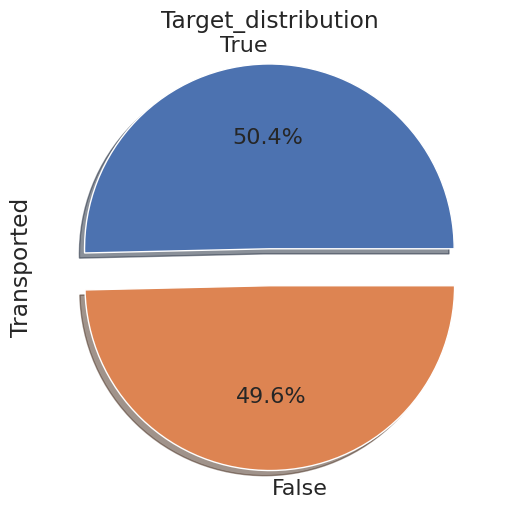

In [8]:
plt.figure(figsize=(6,6))

# Pie plot
train['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target_distribution")

由上面的我们可以看到分布基本是对半分的，所以这个数据集是比较均衡的

**连续性特征**

Text(0.5, 0, 'Age (years)')

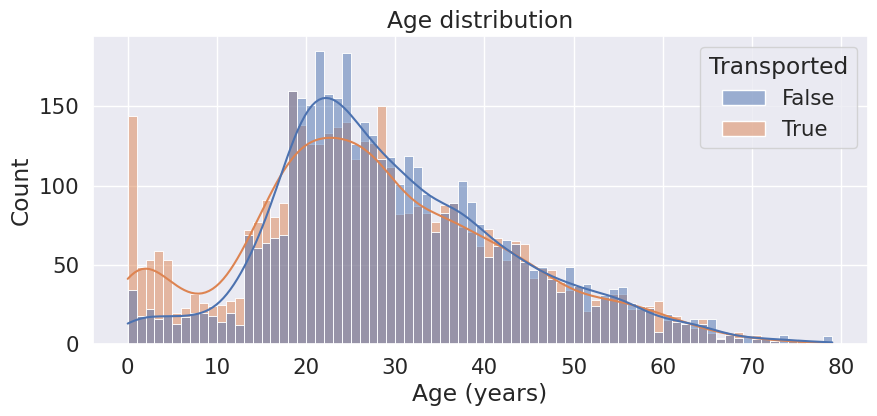

In [9]:
# Figure size
plt.figure(figsize=(10,4))

# 查看传送成功和不成功的样本的年龄分布
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True) # kde:核密度估计

plt.title('Age distribution')
plt.xlabel('Age (years)')

从中可以得到下面的结论：
+ 0-18岁的乘客中，传送成功的比例更高
+ 18-25岁的乘客中，传送成功的比例更低
+ 25岁以上的乘客中，传送成功的和不成功的比例基本相同

这给到我们一个启示可以按照三个年龄段对于数据进行划分，这样可以更好的进行模型的训练

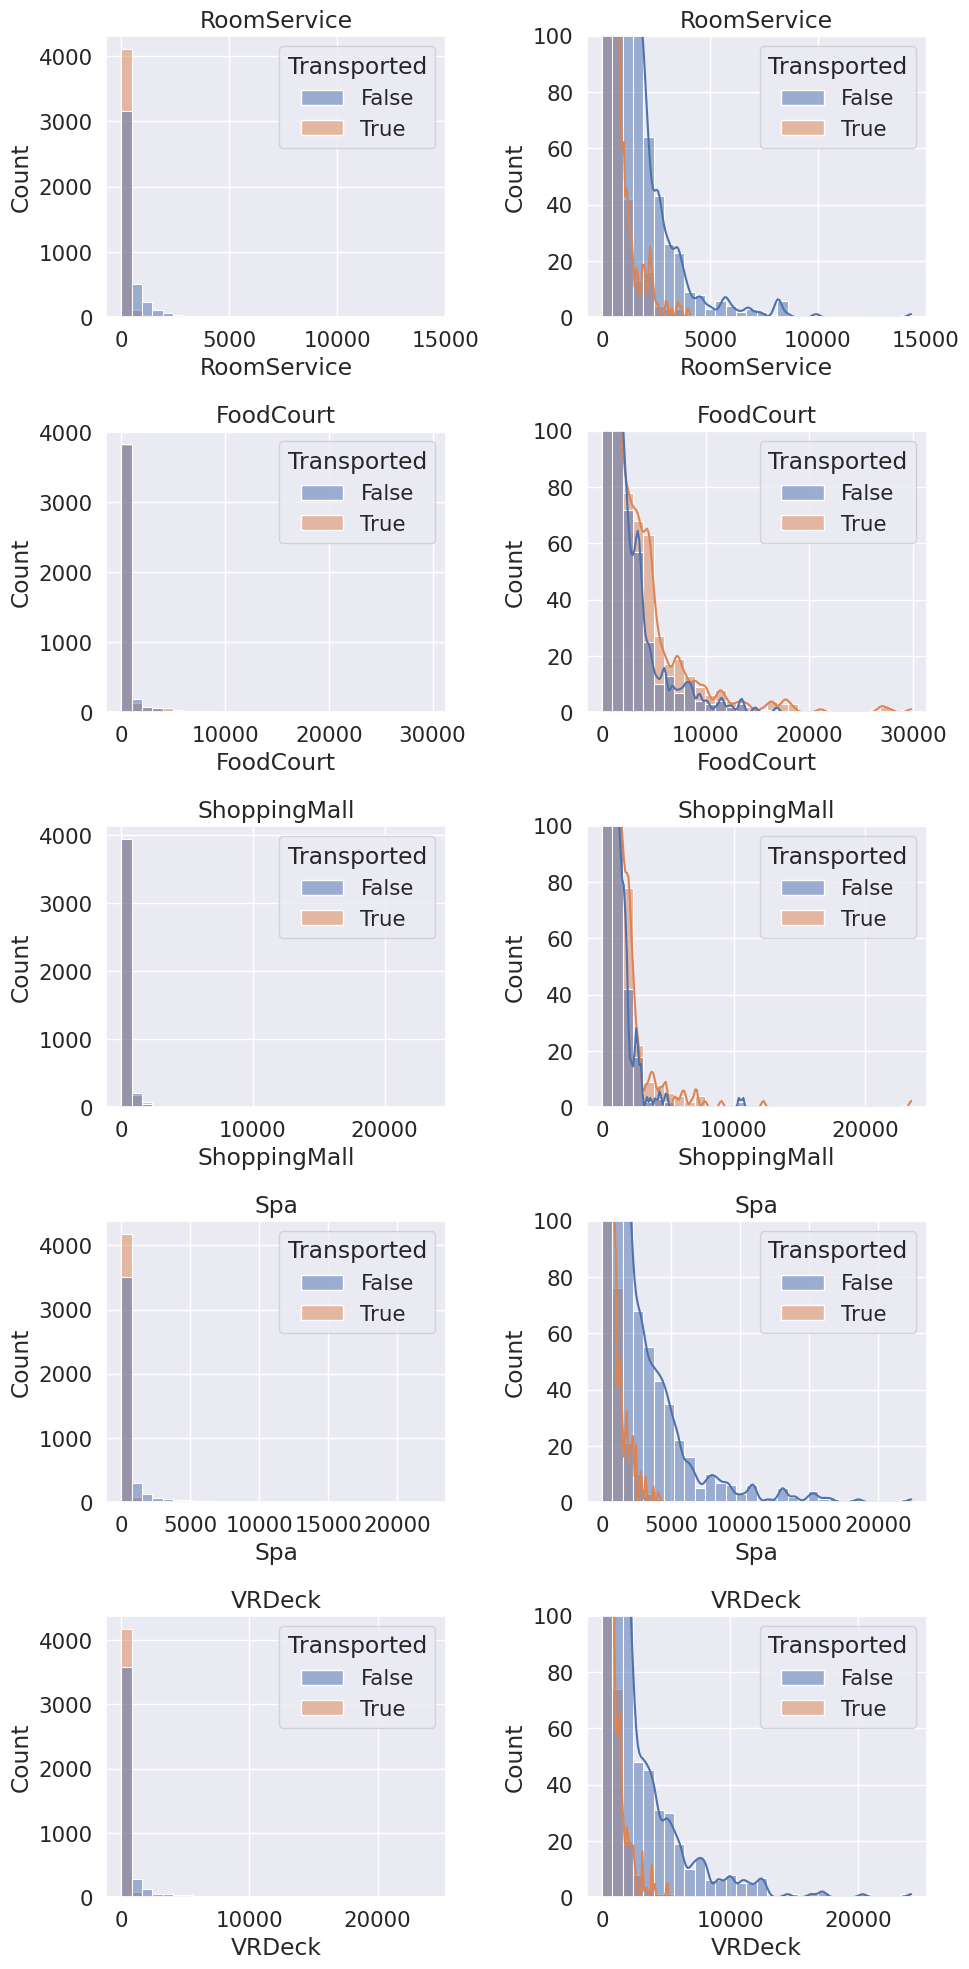

In [10]:
# Expenditure features 花费特征
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)

    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

从中我们可以得到下面的结论：
+ 大多数的人没有花多少钱
+ 花费的分布呈指数衰减（如右图所示）
+ 存在一小部分异常值
+ 被传送的人倾向于花费较少
+ RoomService（客房服务）、Spa（温泉）和VRDeck（虚拟现实甲板）与FoodCourt（美食广场）和ShoppingMall（购物中心）有不同的分布 - 我们可以将其视为奢侈品与基本设施。

这些在数据处理当中可以给我们下面的启示：
+ 创建一个新的特征，跟踪所有5个设施的总支出。
+ 创建一个二进制特征，用于指示该人是否没有花费任何金额（即总支出为0）。
+ 进行对数转换以减小偏度。

**类别特征**

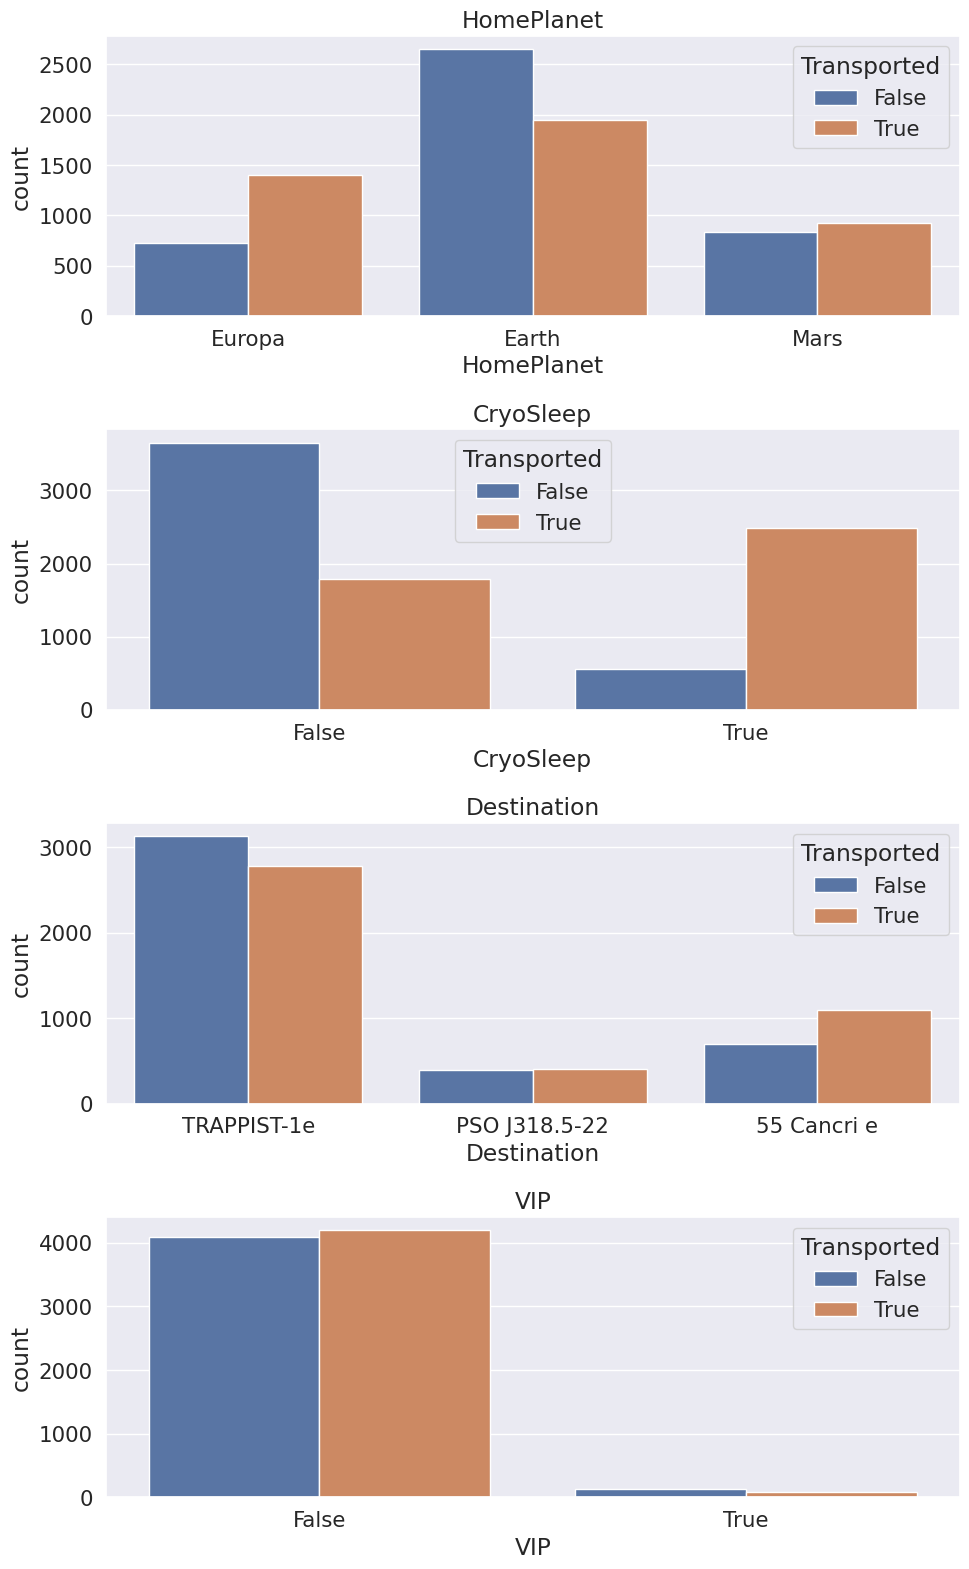

In [11]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

从中我们可以得到下面的结论：
+ VIP这个信息由于在传送成功和不成功的乘客里面基本都是对半分布，因此这个特征对于我们的模型训练没有什么帮助，所以我们可以将其删除
+ CryoSleep很重要，因为在传送成功的乘客中，大多数都是在冷冻睡眠中醒来的

这些在数据处理当中可以给我们下面的启示：
+ 可以将VIP特征删除

**定性特征**

In [12]:
# Qualitative features
qual_feats=['PassengerId', 'Cabin' ,'Name'] # 客舱号，姓名
# qual_feats 意思是 qualitative features

# Preview qualitative features
train[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


*从中我们可以获取下面的信息：*
* PassengerId的形式为gggg_pp，其中gggg表示乘客所在的组，pp表示该组中的编号。
* Cabin的形式为deck/num/side，其中side可以是P表示舷侧（Port），或者是S表示舷侧（Starboard）。

*其中我们可以得到的启示：*
* 我们可以从PassengerId特征中提取组别和组内人数。
* 我们可以从Cabin特征中提取甲板（deck）、编号（number）和舷侧（side）。
* 我们可以从姓名（Name）特征中提取姓氏以识别家庭。


## 特征工程

根据数据探索中获得的方向对于数据进行处理

**年龄**
根据上面的启示，可以看到可以对于年龄的分布进行分组，这样可以更好的在建模的时候利用传送成功率在不同的年龄段的分布

Text(0.5, 1.0, 'Age group distribution')

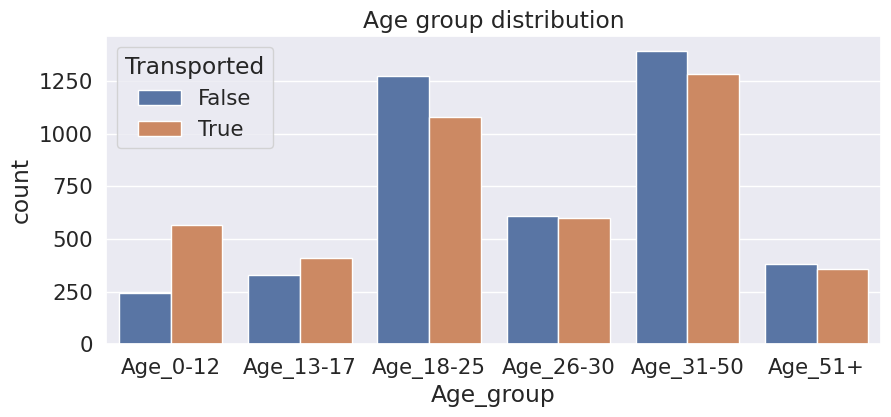

In [13]:
# New features - training set
train['Age_group']=np.nan
train.loc[train['Age']<=12,'Age_group']='Age_0-12'
train.loc[(train['Age']>12) & (train['Age']<18),'Age_group']='Age_13-17'
train.loc[(train['Age']>=18) & (train['Age']<=25),'Age_group']='Age_18-25'
train.loc[(train['Age']>25) & (train['Age']<=30),'Age_group']='Age_26-30'
train.loc[(train['Age']>30) & (train['Age']<=50),'Age_group']='Age_31-50'
train.loc[train['Age']>50,'Age_group']='Age_51+'

# New features - test set
test['Age_group']=np.nan
test.loc[test['Age']<=12,'Age_group']='Age_0-12'
test.loc[(test['Age']>12) & (test['Age']<18),'Age_group']='Age_13-17'
test.loc[(test['Age']>=18) & (test['Age']<=25),'Age_group']='Age_18-25'
test.loc[(test['Age']>25) & (test['Age']<=30),'Age_group']='Age_26-30'
test.loc[(test['Age']>30) & (test['Age']<=50),'Age_group']='Age_31-50'
test.loc[test['Age']>50,'Age_group']='Age_51+'

# Plot distribution of new features
plt.figure(figsize=(10,4))
g=sns.countplot(data=train, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Age group distribution')

不同组内的传送的成功率有差距，基本符合我们之前数据探索当中得出的结论

**消费**

计算总的消费并去定位哪些没有消费的乘客

(0.0, 20000.0)

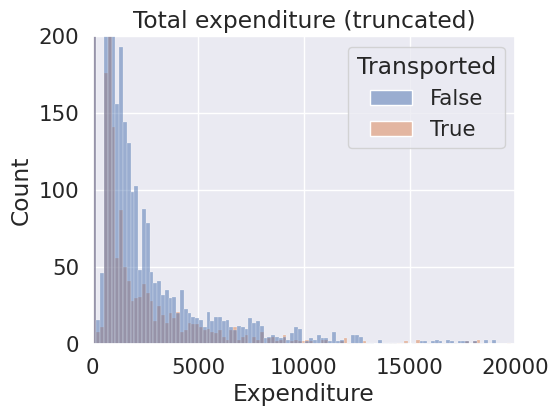

In [14]:
# New features - training set
train['Expenditure']=train[exp_feats].sum(axis=1)
train['No_spending']=(train['Expenditure']==0).astype(int)

# New features - test set
test['Expenditure']=test[exp_feats].sum(axis=1)
test['No_spending']=(test['Expenditure']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])


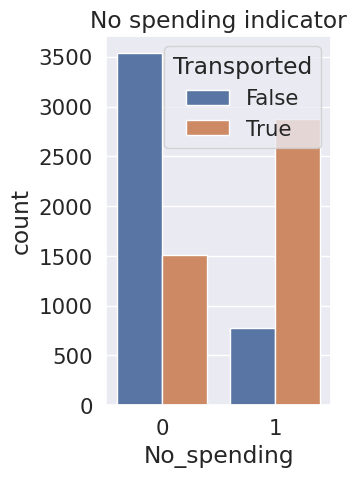

In [15]:
plt.subplot(1,2,2)
sns.countplot(data=train, x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()

其中可以看到消费为0的乘客中，传送成功的比例要高于传送失败的比例，这个特征可以作为一个特征

**乘客的分组**

从乘客的PassengerId中提取出乘客的组别和组内人数

下面的这个比较大回头拿服务器跑一下，我的电脑有点跑不动了

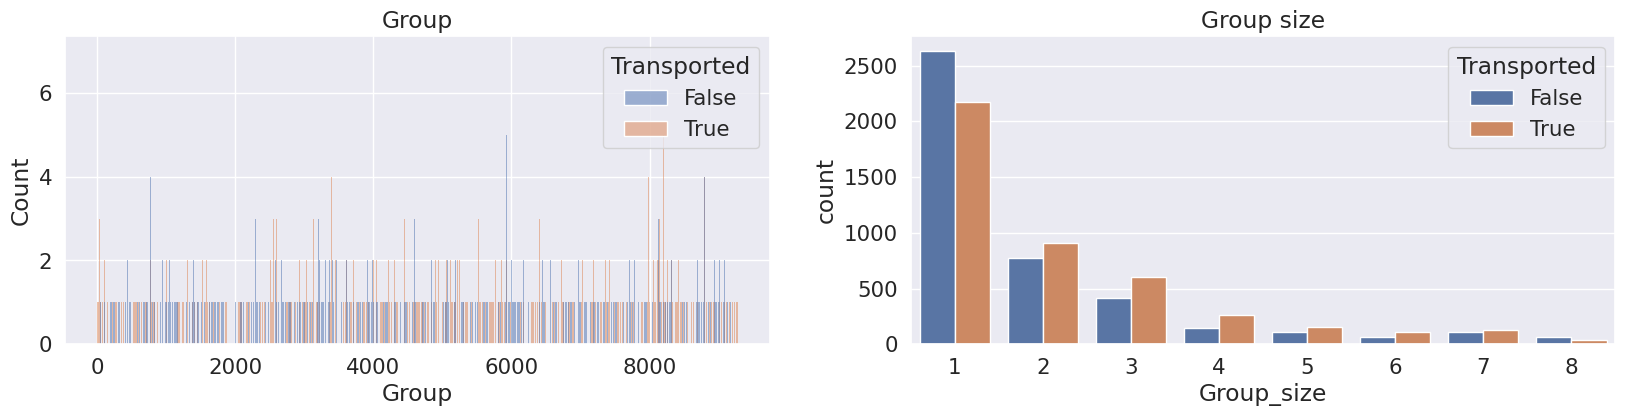

In [16]:
# New feature - Group
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# New feature - Group size
train['Group_size']=train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['Group_size']=test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

我们无法在模型中真正使用“Group”特征，因为它的基数太大（6217），使用独热编码会导致维度爆炸。

另一方面，组大小应该是一个有用的特征。实际上，我们可以通过创建一个“Solo”列进一步压缩该特征，以跟踪某人是否独自旅行。右侧的图表显示，与组大小大于1相比，组大小为1的人更不太可能被传送。

(0.0, 3000.0)

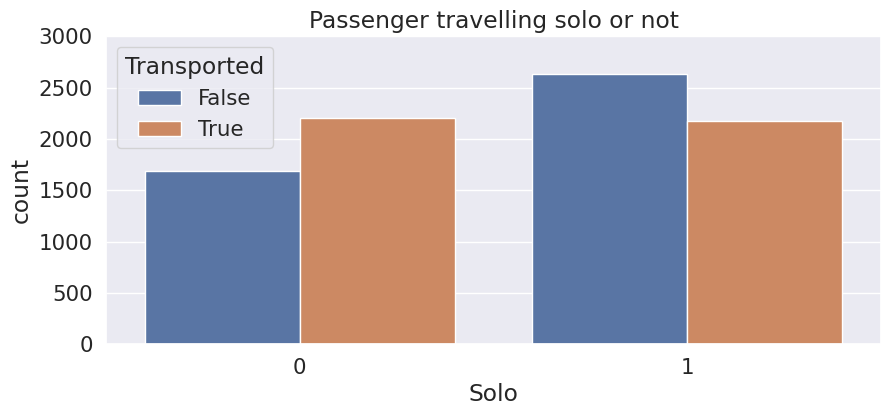

In [17]:
# New feature
train['Solo']=(train['Group_size']==1).astype(int)
test['Solo']=(test['Group_size']==1).astype(int)

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0,3000])

**定位甲板信息**

从舱位特征中提取出甲板信息

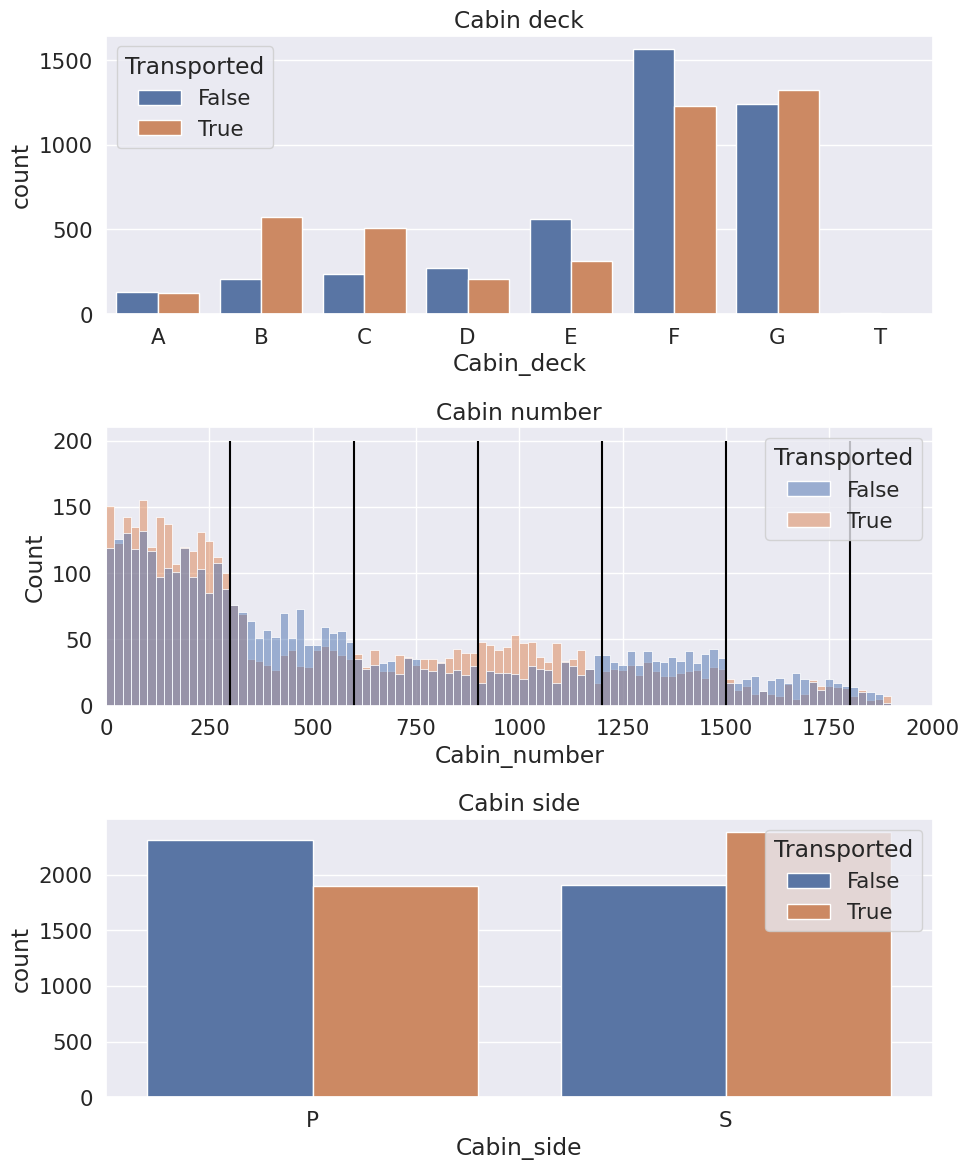

In [18]:
# Replace NaN's with outliers for now (so we can split feature)
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

# New features - training set
train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

# New features - test set
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

# Put Nan's back in (we will fill these later)
train.loc[train['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
train.loc[train['Cabin_number']==9999, 'Cabin_number']=np.nan
train.loc[train['Cabin_side']=='Z', 'Cabin_side']=np.nan
test.loc[test['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
test.loc[test['Cabin_number']==9999, 'Cabin_number']=np.nan
test.loc[test['Cabin_side']=='Z', 'Cabin_side']=np.nan

# Drop Cabin (we don't need it anymore)
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train, x='Cabin_number', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

这个甲板特征里面的T又可能是个异常值，太少了，只有5个

看起来Cabin_number被分组成了每组300个舱室。这意味着我们可以将这个特征压缩成一个分类特征，指示每位乘客所在的舱室组

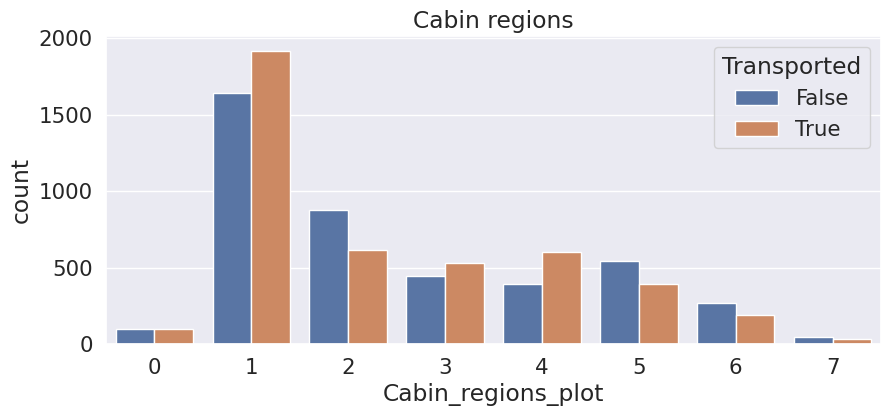

In [19]:
# New features - training set
train['Cabin_region1']=(train['Cabin_number']<300).astype(int)   # one-hot encoding
train['Cabin_region2']=((train['Cabin_number']>=300) & (train['Cabin_number']<600)).astype(int)
train['Cabin_region3']=((train['Cabin_number']>=600) & (train['Cabin_number']<900)).astype(int)
train['Cabin_region4']=((train['Cabin_number']>=900) & (train['Cabin_number']<1200)).astype(int)
train['Cabin_region5']=((train['Cabin_number']>=1200) & (train['Cabin_number']<1500)).astype(int)
train['Cabin_region6']=((train['Cabin_number']>=1500) & (train['Cabin_number']<1800)).astype(int)
train['Cabin_region7']=(train['Cabin_number']>=1800).astype(int)

# New features - test set
test['Cabin_region1']=(test['Cabin_number']<300).astype(int)   # one-hot encoding
test['Cabin_region2']=((test['Cabin_number']>=300) & (test['Cabin_number']<600)).astype(int)
test['Cabin_region3']=((test['Cabin_number']>=600) & (test['Cabin_number']<900)).astype(int)
test['Cabin_region4']=((test['Cabin_number']>=900) & (test['Cabin_number']<1200)).astype(int)
test['Cabin_region5']=((test['Cabin_number']>=1200) & (test['Cabin_number']<1500)).astype(int)
test['Cabin_region6']=((test['Cabin_number']>=1500) & (test['Cabin_number']<1800)).astype(int)
test['Cabin_region7']=(test['Cabin_number']>=1800).astype(int)

# Plot distribution of new features
plt.figure(figsize=(10,4))
train['Cabin_regions_plot']=(train['Cabin_region1']+2*train['Cabin_region2']+3*train['Cabin_region3']+4*train['Cabin_region4']+5*train['Cabin_region5']+6*train['Cabin_region6']+7*train['Cabin_region7']).astype(int)
sns.countplot(data=train, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')
train.drop('Cabin_regions_plot', axis=1, inplace=True)

**姓**

可以根据其中姓的个数去计算这个家庭一共有多少人

Text(0.5, 1.0, 'Family size')

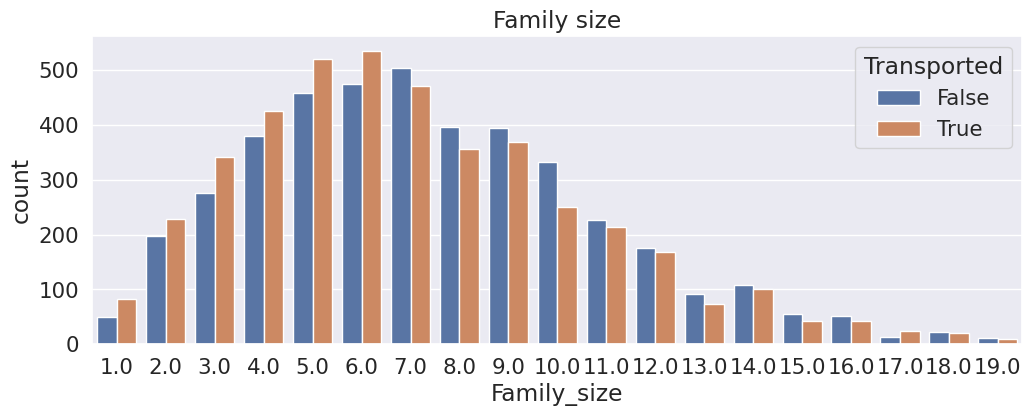

In [20]:
# Replace NaN's with outliers for now (so we can split feature)
train['Name'].fillna('Unknown Unknown', inplace=True)
test['Name'].fillna('Unknown Unknown', inplace=True)

# New feature - Surname
train['Surname']=train['Name'].str.split().str[-1]
test['Surname']=test['Name'].str.split().str[-1]

# New feature - Family size
train['Family_size']=train['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])
test['Family_size']=test['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])

# Put Nan's back in (we will fill these later)
train.loc[train['Surname']=='Unknown','Surname']=np.nan
train.loc[train['Family_size']>100,'Family_size']=np.nan
test.loc[test['Surname']=='Unknown','Surname']=np.nan
test.loc[test['Family_size']>100,'Family_size']=np.nan

# Drop name (we don't need it anymore)
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

# New feature distribution
plt.figure(figsize=(12,4))
sns.countplot(data=train, x='Family_size', hue='Transported')
plt.title('Family size')

上面作图反映了不同人数家庭的个数

## 处理缺失值

合并训练集和测试集来处理缺失值，两个放在一起处理缺失值更有利于从总体上把握特征，能够更好的处理缺失值。
当然在完成缺失值处理之后还是要将训练集和测试集分开的 

In [21]:
# Labels and features
y=train['Transported'].copy().astype(int)
X=train.drop('Transported', axis=1).copy()

# Concatenate dataframes
data=pd.concat([X, test], axis=0).reset_index(drop=True)

**探索缺失值**

In [22]:
# Columns with missing values
na_cols=data.columns[data.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(data[na_cols].isna().sum(), columns=['缺失量'])
mv['缺失比例']=np.round(100*mv['缺失量']/len(data),2)
mv

,缺失量,缺失比例
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


画个热力图来看看缺失值的分布

Text(0.5, 1.0, 'Heatmap of missing values')

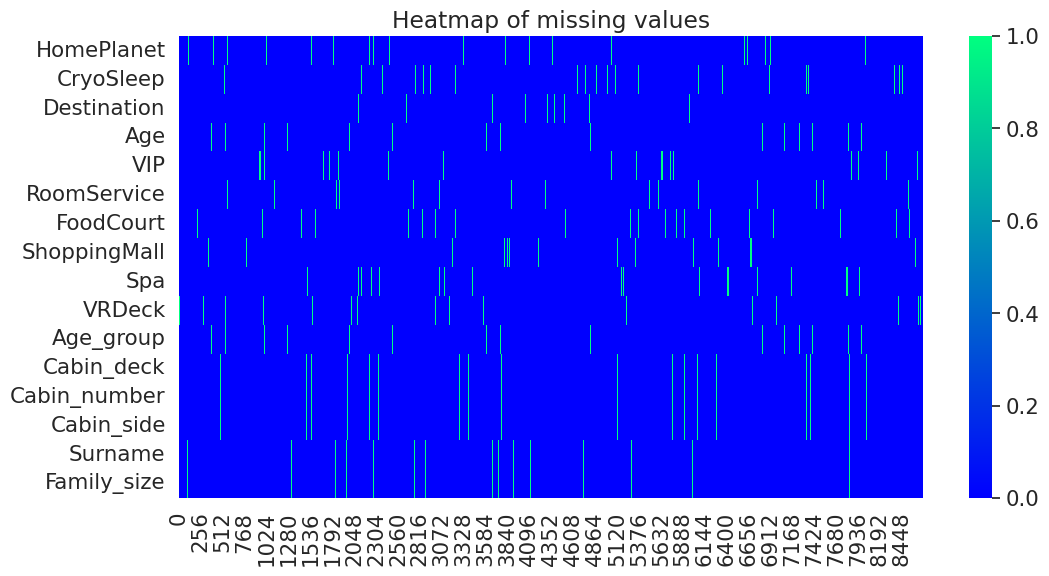

In [23]:
# Heatmap of missing values
plt.figure(figsize=(12,6))
sns.heatmap(train[na_cols].isna().T, cmap='winter')
plt.title('Heatmap of missing values')

从总体上看来缺失值占比大概在2%-3%，这个比例不算大

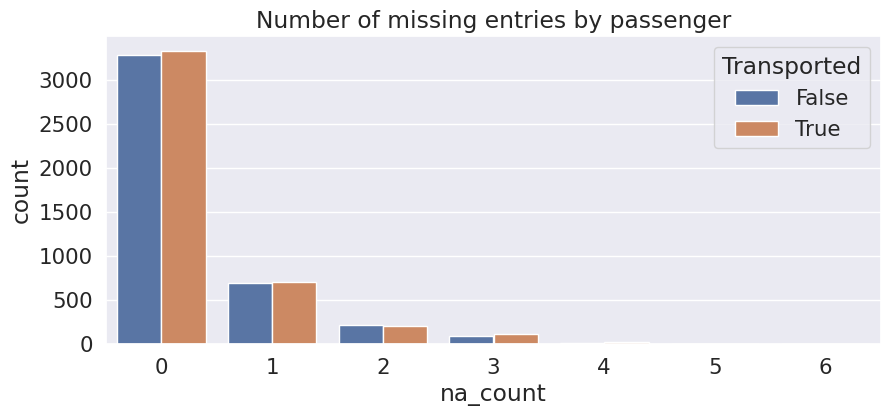

In [24]:
# 统计每个数值缺失的比例
train['na_count']=train.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='na_count', hue='Transported')
plt.title('Number of missing entries by passenger')
train.drop('na_count', axis=1, inplace=True)

可以看到大部分的数据缺失启示都是缺1个数据，有极少数的情况出现了缺了2-3个数据的，但是好在没有缺了更多的数据的

*上面的内容给到的提示*
* 缺失值与目标变量独立，大部分情况下是孤立存在的。
* 尽管数据中只有2%的缺失值，但大约25%的乘客至少有一个缺失值。
* PassengerId是唯一一个没有任何缺失值的（原始）特征。

*从上面的内容中得到的启发*
* 由于大部分缺失值是孤立存在的，与其删除行，填充这些缺失值是有意义的。
* 如果PassengerId与其他特征之间存在关联，我们可以根据该列填充缺失值。


处理缺失值的最简单方法是对连续特征使用中位数，对分类特征使用众数（请参阅本笔记本的第20个版本）。这种方法足够有效，但如果我们想要最大化模型的准确性，我们需要寻找缺失数据中的模式。要做到这一点，可以观察特征的联合分布，例如，同一组的乘客是否倾向于来自同一家庭？显然存在许多组合，因此我们将总结我和其他人发现的有用趋势。

**来自的星球和分组之间的关系**

In [25]:
# Joint distribution of Group and HomePlanet
GHP_gb=data.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0) # unstack:将分组后的数据转换为矩阵
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


In [26]:
# 统计每组Number of unique home planets per group
GHP_gb['n_unique']=GHP_gb.apply(lambda x: sum(x>0), axis=1) # axis=1:按行统计
GHP_gb.head()

HomePlanet,Earth,Europa,Mars,n_unique
Group,,,,
1,0.0,1.0,0.0,1
2,1.0,0.0,0.0,1
3,0.0,2.0,0.0,1
4,1.0,0.0,0.0,1
5,1.0,0.0,0.0,1


In [27]:
# 输出星球数量大于1的组的个数
print(f'\033[94mNumber of groups with more than 1 unique home planet: {sum(GHP_gb["n_unique"]>1)}')

Number of groups with more than 1 unique home planet: 0


由此可见几乎每组的乘客都来自一个相同的星球，那么我们可以按照组别来补充其中来自星球的信息

In [28]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a group with known HomePlanet
GHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

# Fill corresponding missing values
data.loc[GHP_index,'HomePlanet']=data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 288
#HomePlanet missing values after: 157


这就意味着有131个缺失值我们是可以以100%确定把这些缺失值填充上去的

**母星和仓位所在的甲板**

画个热力图看看各个甲板上来自各个星球的人数的分布

<AxesSubplot: xlabel='Cabin_deck', ylabel='HomePlanet'>

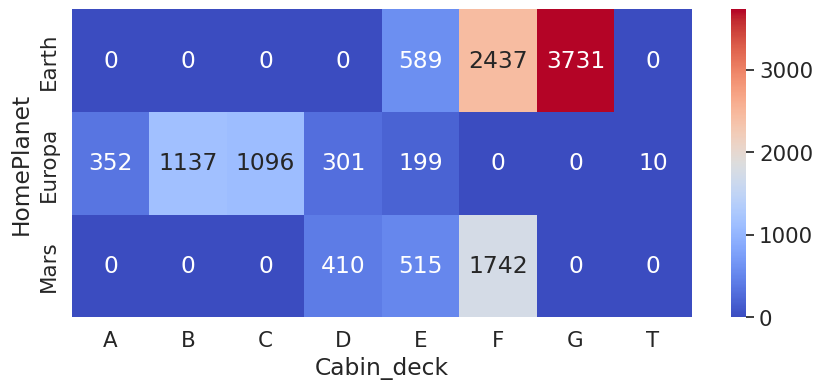

In [29]:
# Joint distribution of CabinDeck and HomePlanet
CDHP_gb=data.groupby(['Cabin_deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')

* 来自欧罗巴的乘客在 A、B、C 或 T 层甲板上。
* 来自地球的乘客在 G 层甲板上。
* 来自多个行星的乘客在 D、E 或 F 层甲板上。

利用这样的一个规律我们可以将A,B,C,T,G甲板上母星缺失的给填补上

In [30]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Decks A, B, C or T came from Europa
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

# Deck G came from Earth
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='G'), 'HomePlanet']='Earth'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 157
#HomePlanet missing values after: 94


**母星和姓**

设想同一个姓的又可能是同一个家庭的，而同一个家庭注定会来自同一个星球，为了验证猜想先来做图看看

Text(0.5, 1.0, 'Number of unique planets per surname')

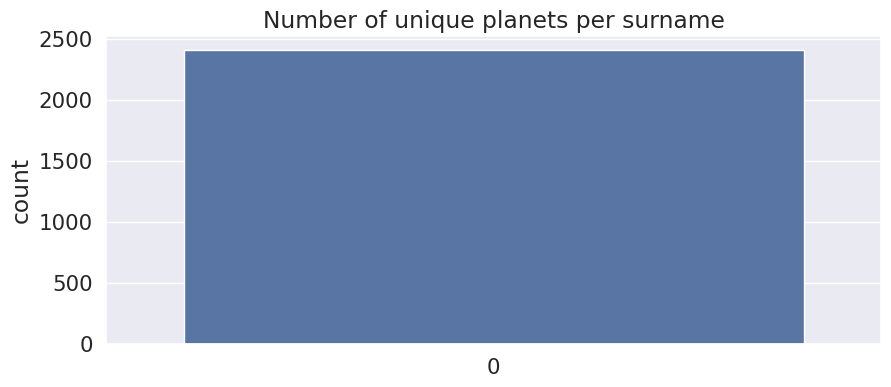

In [31]:
# Joint distribution of Surname and HomePlanet
SHP_gb=data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Countplot of unique values
plt.figure(figsize=(10,4))
sns.countplot((SHP_gb>0).sum(axis=1))
plt.title('Number of unique planets per surname')

In [32]:
# Joint distribution of Surname and HomePlanet
SHP_gb = data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

#展示分组后的数据
SHP_gb.head()

HomePlanet,Earth,Europa,Mars
Surname,,,
Acobson,5.0,0.0,0.0
Acobsond,8.0,0.0,0.0
Adavisons,10.0,0.0,0.0
Adkinson,4.0,0.0,0.0
Admingried,0.0,4.0,0.0


Text(0, 0.5, 'Number of surnames')

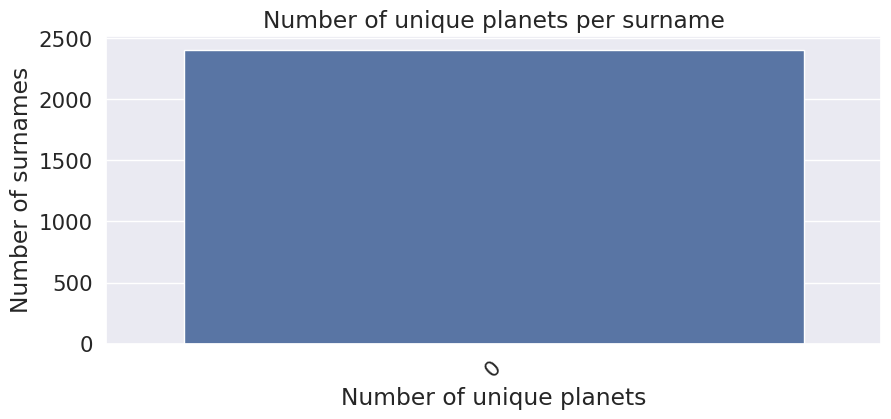

In [33]:
# Countplot of unique values
plt.figure(figsize=(10,4))
sns.countplot((SHP_gb >= 1).sum(axis=1))
plt.title('Number of unique planets per surname')

# 设置横坐标轴上的数值和标签
plt.xticks(rotation=45)
plt.xlabel('Number of unique planets')
plt.ylabel('Number of surnames')

In [34]:
# 输出一个有多个星球的姓氏的个数
print('Number of surnames with more than one planet:',((SHP_gb>0).sum(axis=1)>1).sum())

Number of surnames with more than one planet: 0


综合上面信息可以得知同一个姓氏的都来自同一个星球，因此，我们可以利用姓氏对于来自的星球进行填充

In [35]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a family with known HomePlanet
SHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

# Fill corresponding missing values
data.loc[SHP_index,'HomePlanet']=data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 94
#HomePlanet missing values after: 10


现在来自星球数据缺失就只有10个了！

既然只有10个那么我们不妨来看看剩下的是什么

In [36]:
# 查看还没有被处理的10个数据
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]

,PassengerId,HomePlanet,Destination
2274,2443_01,NaN,TRAPPIST-1e
2631,2817_01,NaN,TRAPPIST-1e
3091,3331_01,NaN,TRAPPIST-1e
4548,4840_01,NaN,TRAPPIST-1e
5762,6108_01,NaN,TRAPPIST-1e
8969,0616_01,NaN,TRAPPIST-1e
10583,4052_01,NaN,TRAPPIST-1e
11913,7065_01,NaN,TRAPPIST-1e
12551,8435_01,NaN,TRAPPIST-1e
12725,8775_01,NaN,TRAPPIST-1e


In [37]:
# 查看还没有被处理的10个数据
data[data['HomePlanet'].isna()]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Surname,Family_size
2274,2443_01,NaN,False,TRAPPIST-1e,31.0,False,1458.0,421.0,76.0,0.0,...,P,1,0,0,0,0,0,0,NaN,NaN
2631,2817_01,NaN,False,TRAPPIST-1e,25.0,False,237.0,0.0,910.0,0.0,...,P,0,1,0,0,0,0,0,Sutty,1.0
3091,3331_01,NaN,False,TRAPPIST-1e,40.0,False,666.0,4.0,83.0,0.0,...,S,0,0,1,0,0,0,0,NaN,NaN
4548,4840_01,NaN,True,TRAPPIST-1e,36.0,False,0.0,0.0,NaN,0.0,...,S,0,0,0,1,0,0,0,NaN,NaN
5762,6108_01,NaN,False,TRAPPIST-1e,13.0,False,206.0,28.0,0.0,1.0,...,S,0,0,0,1,0,0,0,NaN,NaN
8969,0616_01,NaN,False,TRAPPIST-1e,31.0,False,0.0,428.0,NaN,1154.0,...,S,1,0,0,0,0,0,0,Spriney,1.0
10583,4052_01,NaN,False,TRAPPIST-1e,26.0,False,6.0,5903.0,0.0,240.0,...,P,1,0,0,0,0,0,0,Coneveseng,1.0
11913,7065_01,NaN,True,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,...,S,0,1,0,0,0,0,0,Maltorted,2.0
12551,8435_01,NaN,NaN,TRAPPIST-1e,19.0,False,162.0,11.0,0.0,0.0,...,P,0,0,0,0,0,1,0,NaN,NaN
12725,8775_01,NaN,True,TRAPPIST-1e,40.0,False,0.0,0.0,0.0,0.0,...,P,1,0,0,0,0,0,0,Maltorted,2.0


所有剩下的人都是前往TRAPPIST-1e的，所以我们来看看目的地和母星之间的联系

**目的地和母星**

<AxesSubplot: xlabel='HomePlanet', ylabel='Destination'>

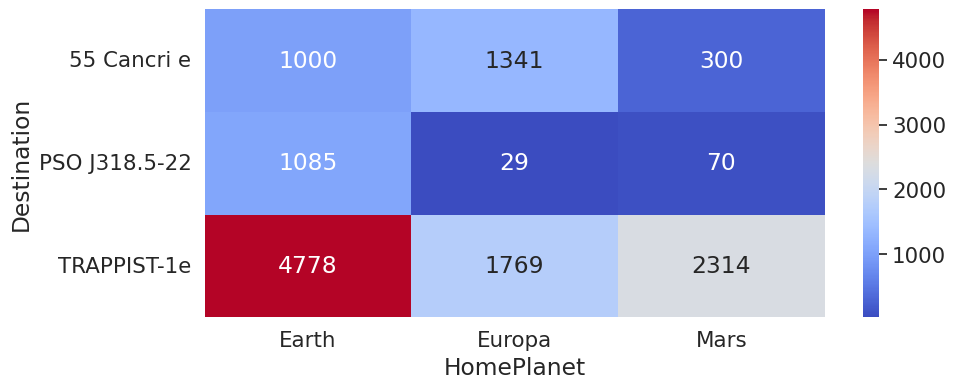

In [38]:
# Joint distribution of HomePlanet and Destination
HPD_gb=data.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')

大多数前往TRAPPIST-1e的人来自地球，因此猜测他们来自那里是有道理的。但请记住之前提到的，没有人来自地球的D层甲板，所以我们需要将它们过滤掉。

In [39]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
data.loc[(data['HomePlanet'].isna()) & ~(data['Cabin_deck']=='D'), 'HomePlanet']='Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='D'), 'HomePlanet']='Mars'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 10
#HomePlanet missing values after: 0


运气不错，现在所有的母星的缺失值都补上了

**姓氏和所在的组**

先来看看姓是不是和之前有相同的规律每个姓都被分在一个组

In [40]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Surname,Family_size
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,P,1,0,0,0,0,0,0,Ofracculy,3.0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,S,1,0,0,0,0,0,0,Vines,4.0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,S,1,0,0,0,0,0,0,Susent,7.0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,S,1,0,0,0,0,0,0,Susent,7.0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,S,1,0,0,0,0,0,0,Santantines,9.0


In [41]:
# Joint distribution of Group and Surname
GSN_gb=data[data['Group_size']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)


In [42]:
GSN_gb.head()

Surname,Acobson,Acobsond,Adavisons,Admingried,Aginge,Ailled,Aillyber,Ainatint,Aindlylid,Ainserfle,...,Woody,Wooes,Wooterston,Workmans,Workmanson,Wriggins,Yanton,Yatters,Yorkland,Youngrayes
Group,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
GSN_gb.shape

(2135, 1631)

In [44]:
# 查看GSB_gb中的数据不为0的值的个数
(GSN_gb>0).sum(axis=1).value_counts()

1    1769
2     322
3      43
4       1
dtype: int64

In [45]:
#统计每行不为0的个数
GSN_gb['count']=(GSN_gb>0).sum(axis=1)

In [46]:
GSN_gb.head()

Surname,Acobson,Acobsond,Adavisons,Admingried,Aginge,Ailled,Aillyber,Ainatint,Aindlylid,Ainserfle,...,Wooes,Wooterston,Workmans,Workmanson,Wriggins,Yanton,Yatters,Yorkland,Youngrayes,count
Group,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [47]:
GSN_gb['count'].value_counts()

1    1769
2     322
3      43
4       1
Name: count, dtype: int64

好像把行号那一列在统计的时候也算进去了，赶紧做个修正

In [48]:
#count列中所有的值-1
GSN_gb['count']=GSN_gb['count']-1

In [49]:
GSN_gb['count'].value_counts()

0    1769
1     322
2      43
3       1
Name: count, dtype: int64

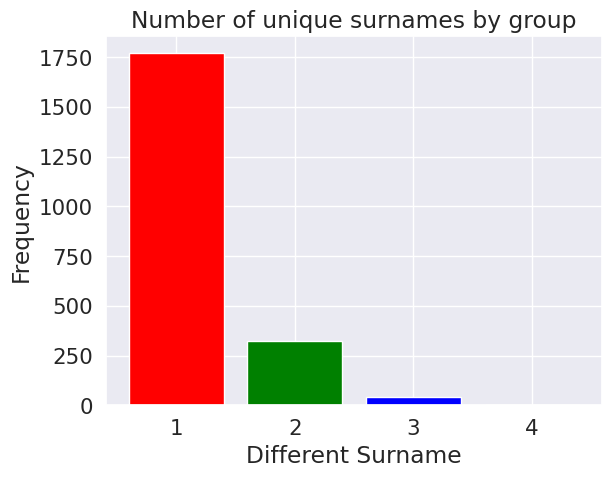

In [50]:
# sns一直出bug我自己手动画吧


x_values = [1, 2, 3, 4]
y_values = [1769, 322, 43, 1]
colors = ['red', 'green', 'blue', 'orange']

plt.bar(x_values, y_values, color=colors)
plt.xlabel('Different Surname')
plt.ylabel('Frequency')
plt.title('Number of unique surnames by group')

plt.show()


大多数（83%）的群组只包含一个家庭。因此，让我们根据该群组中的大多数姓氏来填充缺失的姓氏。

In [51]:
# Missing values before
SN_bef=data['Surname'].isna().sum()

# Passengers with missing Surname and in a group with known majority Surname
GSN_index=data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

# Fill corresponding missing values
data.loc[GSN_index,'Surname']=data.iloc[GSN_index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Surname missing values before:',SN_bef)
print('#Surname missing values after:',data['Surname'].isna().sum())

#Surname missing values before: 294
#Surname missing values after: 155


这是我们能做的最好的处理方式了。我们不必去除所有这些缺失值，因为最终我们会删除姓氏特征。然而，我们可以更新家庭大小特征。

In [52]:
# Replace NaN's with outliers (so we can use map)
data['Surname'].fillna('Unknown', inplace=True)

# Update family size feature
data['Family_size']=data['Surname'].map(lambda x: data['Surname'].value_counts()[x])

# Put NaN's back in place of outliers
data.loc[data['Surname']=='Unknown','Surname']=np.nan

# Say unknown surname means no family
data.loc[data['Family_size']>100,'Family_size']=0

**甲板位置和组号**

In [53]:
# Joint distribution of Group and Cabin features
GCD_gb=data[data['Group_size']>1].groupby(['Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)

In [54]:
GCD_gb.head()

Cabin_deck,A,B,C,D,E,F,G,T
Group,,,,,,,,
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
8,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
20,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0


In [55]:
print(GCD_gb.index)

Int64Index([   3,    6,    8,   17,   20,   31,   32,   40,   44,   45,
            ...
            9220, 9227, 9231, 9238, 9252, 9266, 9267, 9272, 9275, 9280],
           dtype='int64', name='Group', length=2134)


In [56]:
# 重新设置索引
GCD_gb.reset_index(drop=True, inplace=True)

In [57]:
print(GCD_gb.index)

RangeIndex(start=0, stop=2134, step=1)


In [58]:
GCD_gb.head()

Cabin_deck,A,B,C,D,E,F,G,T
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0


In [59]:
GCD_gb['count']=(GCD_gb>0).sum(axis=1)

In [60]:
GCD_gb.head()

Cabin_deck,A,B,C,D,E,F,G,T,count
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2
2,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2
4,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1


In [61]:
GCD_gb['count']=GCD_gb['count']-1

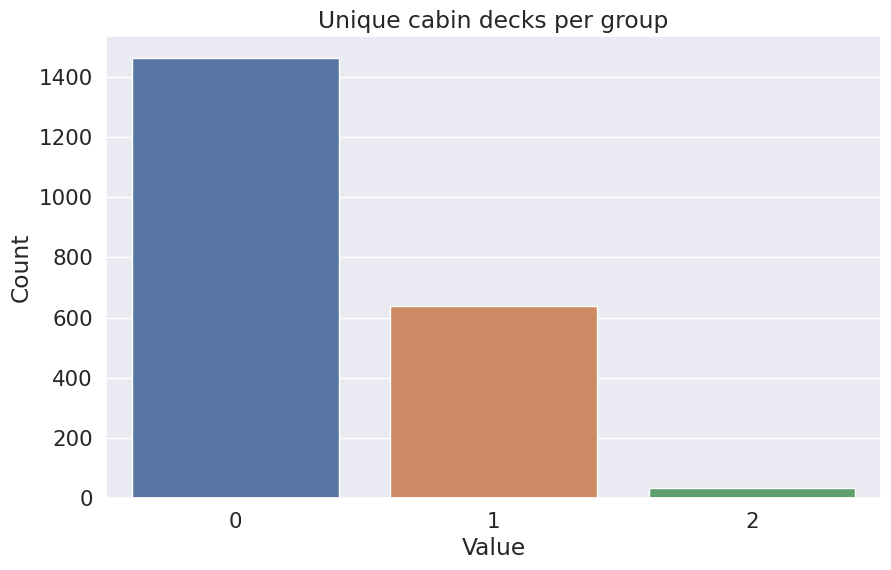

In [62]:
# 统计不同值的个数
value_counts = GCD_gb['count'].value_counts()

# 绘制柱状图
plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Unique cabin decks per group')
plt.show()


In [63]:
GCD_gb.head()

Cabin_deck,A,B,C,D,E,F,G,T,count
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1
2,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1
4,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0


In [64]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Surname,Family_size
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,P,1,0,0,0,0,0,0,Ofracculy,4
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,S,1,0,0,0,0,0,0,Vines,4
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,S,1,0,0,0,0,0,0,Susent,7
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,S,1,0,0,0,0,0,0,Susent,7
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,S,1,0,0,0,0,0,0,Santantines,9


对于上面的的处理过程我自己的思路应该有一点问题我在下面来换一个思路进行一下试验，如果可以的话我应该可以得到我想要的结论

In [65]:
GCD_gb=data[data['Group_size']>1].groupby(['Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)

In [66]:
GCD_gb.head()

Cabin_deck,A,B,C,D,E,F,G,T
Group,,,,,,,,
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
8,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
20,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0


In [67]:
GCS_gb=data[data['Group_size']>1].groupby(['Group','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

In [68]:
GCS_gb.head()

Cabin_side,P,S
Group,,
3,0.0,2.0
6,0.0,2.0
8,3.0,0.0
17,2.0,0.0
20,0.0,6.0


In [69]:
GCS_gb.shape

(2134, 2)

In [70]:
GCS_gb['count']=(GCS_gb>0).sum(axis=1)

In [71]:
GCS_gb.head()

Cabin_side,P,S,count
Group,,,
3,0.0,2.0,1
6,0.0,2.0,1
8,3.0,0.0,1
17,2.0,0.0,1
20,0.0,6.0,1


In [72]:
GCS_gb['count']=GCS_gb['count']-1

In [73]:
GCS_gb.head()

Cabin_side,P,S,count
Group,,,
3,0.0,2.0,0
6,0.0,2.0,0
8,3.0,0.0,0
17,2.0,0.0,0
20,0.0,6.0,0


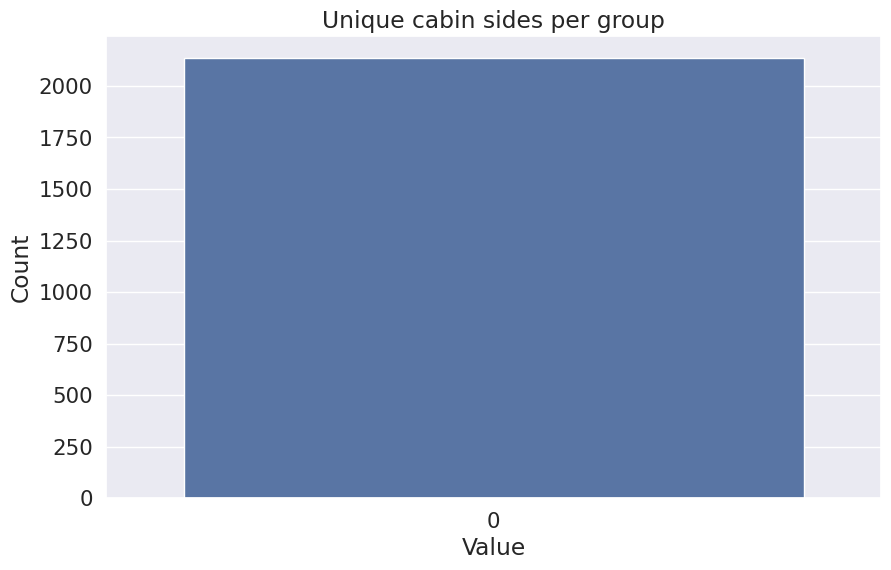

In [74]:
# 统计不同值的个数
value_counts = GCS_gb['count'].value_counts()

# 绘制柱状图
plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Unique cabin sides per group')
plt.show()

可以看到所有的相同组的人都在甲板相同的side，因此可以利用这样一点来补充所在甲板的位置

In [75]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Passengers with missing Cabin side and in a group with known Cabin side
GCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Group']).isin(GCS_gb.index)].index

# Fill corresponding missing values
data.loc[GCS_index,'Cabin_side']=data.iloc[GCS_index,:]['Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 299
#Cabin_side missing values after: 162


**甲板side和姓氏之间的关系**

Text(0.5, 1.0, 'Ratio of cabin side by surname')

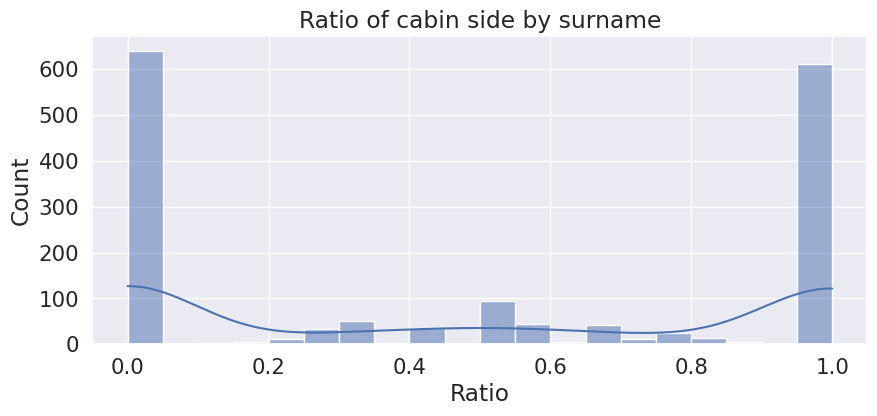

In [76]:
# Joint distribution of Surname and Cabin side
SCS_gb=data[data['Group_size']>1].groupby(['Surname','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

# Ratio of sides
SCS_gb['Ratio']=SCS_gb['P']/(SCS_gb['P']+SCS_gb['S'])

# Histogram of ratio
plt.figure(figsize=(10,4))
sns.histplot(SCS_gb['Ratio'], kde=True, binwidth=0.05)
plt.title('Ratio of cabin side by surname')

In [77]:
# Print proportion
print('家庭成员在同一侧所占的百分比', 100*np.round((SCS_gb['Ratio'].isin([0,1])).sum()/len(SCS_gb),3),'%')

# Another view of the same information
SCS_gb.head()

家庭成员在同一侧所占的百分比 76.7 %


Cabin_side,P,S,Ratio
Surname,,,
Acobson,0.0,3.0,0.0
Acobsond,3.0,0.0,1.0
Adavisons,6.0,0.0,1.0
Admingried,0.0,4.0,0.0
Aginge,3.0,0.0,1.0


这表明家庭成员倾向于在同一侧的舱位上（77% 的家庭成员完全在同一侧）。
因此我们利用这样的规律来弥补缺失值

In [78]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Drop ratio column
SCS_gb.drop('Ratio', axis=1, inplace=True)

# Passengers with missing Cabin side and in a family with known Cabin side
SCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Surname']).isin(SCS_gb.index)].index

# Fill corresponding missing values
data.loc[SCS_index,'Cabin_side']=data.iloc[SCS_index,:]['Surname'].map(lambda x: SCS_gb.idxmax(axis=1)[x])

# Drop surname (we don't need it anymore)
data.drop('Surname', axis=1, inplace=True)

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 162
#Cabin_side missing values after: 66


剩下的缺失值将被替换为异常值。这是因为我们实际上不知道应该将这两个（平衡的）侧面中的哪一个分配给缺失值。

In [79]:
# Value counts
data['Cabin_side'].value_counts()

S    6504
P    6400
Name: Cabin_side, dtype: int64

下面就先把这里面全部填上异常值Z，如果后面有办法再解决吧# Missing values before

In [80]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Fill remaining missing values with outlier
data.loc[data['Cabin_side'].isna(),'Cabin_side']='Z'

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 66
#Cabin_side missing values after: 0


**所在的船舱甲板和分组**

之前的分析中提到过来自相同家庭的成一半在同一个分组当中，利用这样的一个规律先来进行填充一下

In [81]:
# Missing values before
CD_bef=data['Cabin_deck'].isna().sum()

# Passengers with missing Cabin deck and in a group with known majority Cabin deck
GCD_index=data[data['Cabin_deck'].isna()][(data[data['Cabin_deck'].isna()]['Group']).isin(GCD_gb.index)].index

# Fill corresponding missing values
data.loc[GCD_index,'Cabin_deck']=data.iloc[GCD_index,:]['Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Cabin_deck missing values before:',CD_bef)
print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 299
#Cabin_deck missing values after: 162


**甲板和来自的星球**

In [82]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_number,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,0.0,P,1,0,0,0,0,0,0,4
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,0.0,S,1,0,0,0,0,0,0,4
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,0.0,S,1,0,0,0,0,0,0,7
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,0.0,S,1,0,0,0,0,0,0,7
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,1.0,S,1,0,0,0,0,0,0,9


In [83]:
# Joint distribution
data.groupby(['HomePlanet','Destination','Solo','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)

Cabin_deck                         A      B      C      D      E       F  \
HomePlanet Destination   Solo                                              
Earth      55 Cancri e   0       0.0    0.0    0.0    0.0   20.0    90.0   
                         1       0.0    0.0    0.0    0.0   47.0   289.0   
           PSO J318.5-22 0       0.0    0.0    0.0    0.0   18.0    67.0   
                         1       0.0    0.0    0.0    0.0   25.0   262.0   
           TRAPPIST-1e   0       0.0    0.0    0.0    0.0  128.0   425.0   
                         1       0.0    0.0    0.0    0.0  343.0  1310.0   
Europa     55 Cancri e   0      96.0  377.0  313.0   59.0   35.0     0.0   
                         1      67.0  141.0  159.0   46.0   34.0     0.0   
           PSO J318.5-22 0       2.0    5.0   11.0    0.0    0.0     0.0   
                         1       0.0    0.0   10.0    0.0    0.0     0.0   
           TRAPPIST-1e   0     148.0  445.0  414.0  119.0   51.0     0.0   
                         1      43.0  170.0  194.0   82.0   78.0     0.0   
Mars       55 Cancri e   0       0.0    0.0    0.0   32.0   15.0   104.0   
                         1       0.0    0.0    0.0   40.0   16.0    92.0   
           PSO J318.5-22 0       0.0    0.0    0.0    8.0    9.0    14.0   
                         1       0.0    0.0    0.0    9.0    7.0    21.0   
           TRAPPIST-1e   0       0.0    0.0    0.0  161.0  211.0   775.0   
                         1       0.0    0.0    0.0  159.0  262.0   722.0   

Cabin_deck                          G    T  
HomePlanet Destination   Solo               
Earth      55 Cancri e   0      272.0  0.0  
                         1      269.0  0.0  
           PSO J318.5-22 0      230.0  0.0  
                         1      466.0  0.0  
           TRAPPIST-1e   0     1046.0  0.0  
                         1     1462.0  0.0  
Europa     55 Cancri e   0        0.0  2.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  1.0  
                         1        0.0  8.0  
Mars       55 Cancri e   0        0.0  0.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  0.0  
                         1        0.0  0.0

***观察数据我们可以得到下面的结论***
- 火星的乘客最有可能在 F 层甲板上。
- 欧罗巴的乘客（大致上）如果是独自旅行，则最有可能在 C 层甲板上，否则可能在 B 层甲板上。
- 地球的乘客（大致上）最有可能在 G 层甲板上。

利用上面发现的这些规律我们来对于缺失的甲板的数据进行填充

In [84]:
# Missing values before
CD_bef=data['Cabin_deck'].isna().sum()

# Fill missing values using the mode
na_rows_CD=data.loc[data['Cabin_deck'].isna(),'Cabin_deck'].index
data.loc[data['Cabin_deck'].isna(),'Cabin_deck']=data.groupby(['HomePlanet','Destination','Solo'])['Cabin_deck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CD]

# Print number of missing values left
print('#Cabin_deck missing values before:',CD_bef)
print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 162
#Cabin_deck missing values after: 2


In [85]:
# 展示cabin_deck缺失的数据
data[data['Cabin_deck'].isna()]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_number,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
5710,6048_01,Mars,True,NaN,25.0,False,0.0,0.0,0.0,0.0,...,NaN,S,0,0,0,0,0,0,0,8
6112,6451_01,Mars,False,NaN,37.0,False,610.0,NaN,410.0,148.0,...,NaN,Z,0,0,0,0,0,0,0,4


In [86]:
data.dtypes

PassengerId       object
HomePlanet        object
CryoSleep         object
Destination       object
Age              float64
VIP               object
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
Age_group         object
Expenditure      float64
No_spending        int64
Group              int64
Group_size         int64
Solo               int64
Cabin_deck        object
Cabin_number     float64
Cabin_side        object
Cabin_region1      int64
Cabin_region2      int64
Cabin_region3      int64
Cabin_region4      int64
Cabin_region5      int64
Cabin_region6      int64
Cabin_region7      int64
Family_size        int64
dtype: object

In [87]:
print(data['Cabin_deck'])

0        B
1        F
2        A
3        A
4        F
        ..
12965    G
12966    G
12967    D
12968    D
12969    G
Name: Cabin_deck, Length: 12970, dtype: object


In [88]:
# 把缺失的cabin_deck用F填充
data.loc[data['Cabin_deck'].isna(),'Cabin_deck']='F'

In [89]:
print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

#Cabin_deck missing values after: 0


**CabinNumber and CabinDeck**

Text(0.5, 1.0, 'Cabin_number vs group coloured by group')

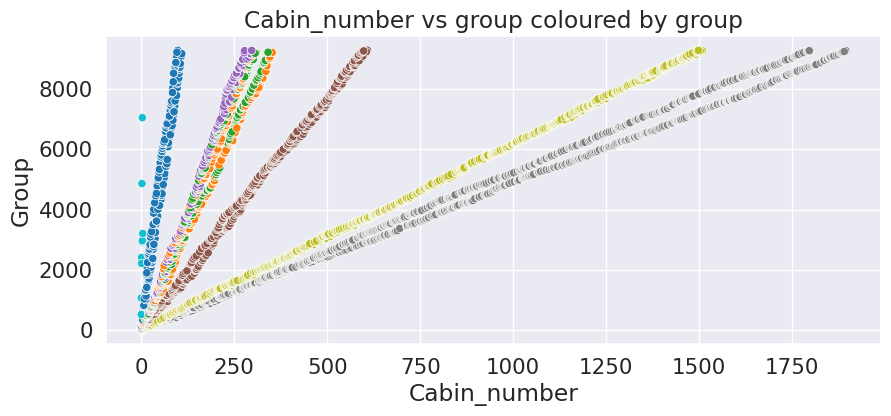

In [90]:
# Scatterplot
plt.figure(figsize=(10,4))
sns.scatterplot(x=data['Cabin_number'], y=data['Group'], c=LabelEncoder().fit_transform(data.loc[~data['Cabin_number'].isna(),'Cabin_deck']), cmap='tab10')
plt.title('Cabin_number vs group coloured by group')

这里存在一个有趣的模式。舱位号和组号在每个甲板上共享线性关系。因此，我们可以通过在每个甲板上使用线性回归来推断缺失的舱位号，以获得一个近似的舱位号。

In [91]:
# Missing values before
CN_bef=data['Cabin_number'].isna().sum()

# Extrapolate linear relationship on a deck by deck basis
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    # Features and labels
    X_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']
    y_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']
    X_test_CN=data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']

    # Linear regression
    model_CN=LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
    preds_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))
    
    # Fill missing values with predictions
    data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']=preds_CN.astype(int)

# Print number of missing values left
print('#Cabin_number missing values before:',CN_bef)
print('#Cabin_number missing values after:',data['Cabin_number'].isna().sum())

#Cabin_number missing values before: 299
#Cabin_number missing values after: 0


在补全缺失之后来更新一下甲板的分组

In [92]:
# One-hot encode cabin regions
data['Cabin_region1']=(data['Cabin_number']<300).astype(int)
data['Cabin_region2']=((data['Cabin_number']>=300) & (data['Cabin_number']<600)).astype(int)
data['Cabin_region3']=((data['Cabin_number']>=600) & (data['Cabin_number']<900)).astype(int)
data['Cabin_region4']=((data['Cabin_number']>=900) & (data['Cabin_number']<1200)).astype(int)
data['Cabin_region5']=((data['Cabin_number']>=1200) & (data['Cabin_number']<1500)).astype(int)
data['Cabin_region6']=((data['Cabin_number']>=1500) & (data['Cabin_number']<1800)).astype(int)
data['Cabin_region7']=(data['Cabin_number']>=1800).astype(int)

In [93]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_number,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,0.0,P,1,0,0,0,0,0,0,4
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,0.0,S,1,0,0,0,0,0,0,4
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,0.0,S,1,0,0,0,0,0,0,7
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,0.0,S,1,0,0,0,0,0,0,7
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,1.0,S,1,0,0,0,0,0,0,9


**VIP**

In [94]:
data['VIP'].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

由此可见VIP是一个非常不平衡的量，是VIP的人其实只占据了极少数，因此我们准确率最高的方法其实就是把缺失的全部标记成为不是VIP

In [95]:
# Missing values before
V_bef=data['VIP'].isna().sum()

# Fill missing values with mode
data.loc[data['VIP'].isna(),'VIP']=False

# Print number of missing values left
print('#VIP missing values before:',V_bef)
print('#VIP missing values after:',data['VIP'].isna().sum())

#VIP missing values before: 296
#VIP missing values after: 0


**年龄**

In [96]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_number,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,0.0,P,1,0,0,0,0,0,0,4
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,0.0,S,1,0,0,0,0,0,0,4
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,0.0,S,1,0,0,0,0,0,0,7
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,0.0,S,1,0,0,0,0,0,0,7
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,1.0,S,1,0,0,0,0,0,0,9


In [97]:
# Joint distribution
data.groupby(['HomePlanet','No_spending','Solo','Cabin_deck'])['Age'].median().unstack().fillna(0)

Cabin_deck                      A     B     C     D     E     F     G     T
HomePlanet No_spending Solo                                                
Earth      0           0      0.0   0.0   0.0   0.0  24.0  25.0  28.0   0.0
                       1      0.0   0.0   0.0   0.0  25.0  24.0  26.0   0.0
           1           0      0.0   0.0   0.0   0.0   7.0  16.0   8.0   0.0
                       1      0.0   0.0   0.0   0.0  21.0  21.5  23.0   0.0
Europa     0           0     35.0  34.0  33.0  33.0  34.0   0.0   0.0  44.0
                       1     35.0  36.0  35.5  34.0  35.0   0.0   0.0  35.0
           1           0     30.0  27.0  28.5  27.0  28.0   0.0   0.0   0.0
                       1     37.5  34.0  35.0  31.0  33.0   0.0   0.0   0.0
Mars       0           0      0.0   0.0   0.0  30.0  29.0  29.0   0.0   0.0
                       1      0.0   0.0   0.0  31.0  28.5  30.0   0.0   0.0
           1           0      0.0   0.0   0.0  29.5  26.0  18.0   0.0   0.0
                       1      0.0   0.0   0.0  33.0  30.0  29.5   0.0   0.0

年龄在家乡星球、团队规模、花费和舱位甲板等许多特征上都存在变化，因此我们将根据这些子组的中位数来填补缺失值。

In [98]:
# Missing values before
A_bef=data[exp_feats].isna().sum().sum()

# Fill missing values using the median
na_rows_A=data.loc[data['Age'].isna(),'Age'].index
data.loc[data['Age'].isna(),'Age']=data.groupby(['HomePlanet','No_spending','Solo','Cabin_deck'])['Age'].transform(lambda x: x.fillna(x.median()))[na_rows_A]

# Print number of missing values left
print('#Age missing values before:',A_bef)
print('#Age missing values after:',data['Age'].isna().sum())

#Age missing values before: 1410
#Age missing values after: 0


用新的数据来更新之前的年龄段分组

In [99]:
# Update age group feature
data.loc[data['Age']<=12,'Age_group']='Age_0-12'
data.loc[(data['Age']>12) & (data['Age']<18),'Age_group']='Age_13-17'
data.loc[(data['Age']>=18) & (data['Age']<=25),'Age_group']='Age_18-25'
data.loc[(data['Age']>25) & (data['Age']<=30),'Age_group']='Age_26-30'
data.loc[(data['Age']>30) & (data['Age']<=50),'Age_group']='Age_31-50'
data.loc[data['Age']>50,'Age_group']='Age_51+'

是否在冬眠

如果一个乘客没有消费记录那他大概率会在冬眠，如果有消费记录，那在冬眠的可能性其实就不大

In [100]:
# Joint distribution
data.groupby(['No_spending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
No_spending,,
0,7339.0,0.0
1,740.0,4581.0


In [101]:
# Missing values before
CSL_bef=data['CryoSleep'].isna().sum()

# Fill missing values using the mode
na_rows_CSL=data.loc[data['CryoSleep'].isna(),'CryoSleep'].index
data.loc[data['CryoSleep'].isna(),'CryoSleep']=data.groupby(['No_spending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CSL]

# Print number of missing values left
print('#CryoSleep missing values before:',CSL_bef)
print('#CryoSleep missing values after:',data['CryoSleep'].isna().sum())

#CryoSleep missing values before: 310
#CryoSleep missing values after: 0


**消费和冬眠之间的关系**

先来验证一下我们之前的猜想是没有错的，也就是说冬眠的人是没有消费的

In [102]:
print('冬眠乘客的最大消费:',data.loc[data['CryoSleep']==True,exp_feats].sum(axis=1).max())

冬眠乘客的最大消费: 0.0


非常好的结果，恰好符合我们之前的猜想

In [103]:
# Missing values before
E_bef=data[exp_feats].isna().sum().sum()

# CryoSleep has no expenditure
for col in exp_feats:
    data.loc[(data[col].isna()) & (data['CryoSleep']==True), col]=0

# Print number of missing values left
print('#Expenditure missing values before:',E_bef)
print('#Expenditure missing values after:',data[exp_feats].isna().sum().sum())

#Expenditure missing values before: 1410
#Expenditure missing values after: 866


花费在许多特征上存在差异，但我们只会使用家乡星球、独自旅行以及年龄组来填补缺失值，以防止过拟合。我们还将使用平均值而不是中位数，因为很大一部分乘客没有花费，中位数通常为0。请注意，年龄在12岁以下的人不会有任何花费。

In [104]:
# Joint distribution
data.groupby(['HomePlanet','Solo','Age_group'])['Expenditure'].mean().unstack().fillna(0)

Age_group        Age_0-12    Age_13-17    Age_18-25    Age_26-30    Age_31-50  \
HomePlanet Solo                                                                 
Earth      0          0.0   724.902222   789.700555   841.093596   736.655773   
           1          0.0   693.014898   779.395942   795.420690   794.818627   
Europa     0          0.0  1153.160256  2652.013298  3534.668246  3975.774005   
           1          0.0     0.000000  2489.888889  3806.000000  3949.939929   
Mars       0          0.0  1176.839286  1161.808333  1247.098361  1143.671916   
           1          0.0  1687.261538  1075.341146  1107.122677  1110.392045   

Age_group            Age_51+  
HomePlanet Solo               
Earth      0      733.649573  
           1      826.366972  
Europa     0     3483.639004  
           1     3952.085526  
Mars       0     1345.419643  
           1     1100.298387

In [105]:
# Missing values before
E_bef=data[exp_feats].isna().sum().sum()

# Fill remaining missing values using the median
for col in exp_feats:
    na_rows=data.loc[data[col].isna(),col].index
    data.loc[data[col].isna(),col]=data.groupby(['HomePlanet','Solo','Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]
    
# Print number of missing values left
print('#Expenditure missing values before:',E_bef)
print('#Expenditure missing values after:',data[exp_feats].isna().sum().sum())

#Expenditure missing values before: 866
#Expenditure missing values after: 0


最后，我们可以使用这些新的数据点更新花费（expenditure）和无花费（no_spending）特征。

In [106]:
# Update expenditure and no_spending
data['Expenditure']=data[exp_feats].sum(axis=1)
data['No_spending']=(data['Expenditure']==0).astype(int)

看看有没有没有处理完的漏网之鱼

In [107]:
data.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Destination      274
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Age_group          0
Expenditure        0
No_spending        0
Group              0
Group_size         0
Solo               0
Cabin_deck         0
Cabin_number       0
Cabin_side         0
Cabin_region1      0
Cabin_region2      0
Cabin_region3      0
Cabin_region4      0
Cabin_region5      0
Cabin_region6      0
Cabin_region7      0
Family_size        0
dtype: int64

好吧还有目的地没有处理完，那接着来处理目的地吧

**目的地**

In [108]:
# 输出Destination 中不同值的个数
data['Destination'].value_counts()

TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
Name: Destination, dtype: int64

In [109]:
#输出 每个HomePlanet 去不同Destination的人数
HPD_gb=data.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)
HPD_gb.shape

(3, 3)

In [110]:
print(HPD_gb)

Destination  55 Cancri e  PSO J318.5-22  TRAPPIST-1e
HomePlanet                                          
Earth               1000           1085         4785
Europa              1341             29         1769
Mars                 300             70         2317


In [111]:
# 输出每个Cabin_deck 去不同Destination的人数
CDD_gb=data.groupby(['Cabin_deck','Destination'])['Destination'].size().unstack().fillna(0)
CDD_gb.shape

(8, 3)

In [112]:
print(CDD_gb)

Destination  55 Cancri e  PSO J318.5-22  TRAPPIST-1e
Cabin_deck                                          
A                  163.0            2.0        191.0
B                  518.0            5.0        615.0
C                  484.0           22.0        624.0
D                  177.0           17.0        521.0
E                  167.0           59.0       1073.0
F                  589.0          366.0       3259.0
G                  541.0          713.0       2579.0
T                    2.0            0.0          9.0


In [113]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_number,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,0.0,P,1,0,0,0,0,0,0,4
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,0.0,S,1,0,0,0,0,0,0,4
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,0.0,S,1,0,0,0,0,0,0,7
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,0.0,S,1,0,0,0,0,0,0,7
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,1.0,S,1,0,0,0,0,0,0,9


In [114]:
HPD_gb=data.groupby(['HomePlanet','Cabin_deck','Destination'])['Destination'].size().unstack().fillna(0)

In [115]:
print(HPD_gb)

Destination            55 Cancri e  PSO J318.5-22  TRAPPIST-1e
HomePlanet Cabin_deck                                         
Earth      E                  67.0           43.0        471.0
           F                 392.0          329.0       1735.0
           G                 541.0          713.0       2579.0
Europa     A                 163.0            2.0        191.0
           B                 518.0            5.0        615.0
           C                 484.0           22.0        624.0
           D                 105.0            0.0        201.0
           E                  69.0            0.0        129.0
           T                   2.0            0.0          9.0
Mars       D                  72.0           17.0        320.0
           E                  31.0           16.0        473.0
           F                 197.0           37.0       1524.0


看来无论怎么分去TRAPPIST-1e的人数都是子组里面最多的，那就直接填上吧，不折腾了

In [116]:
# Missing values before
D_bef=data['Destination'].isna().sum()

# Fill missing Destination values with mode
data.loc[(data['Destination'].isna()), 'Destination']='TRAPPIST-1e'

# Print number of missing values left
print('#Destination missing values before:',D_bef)
print('#Destination missing values after:',data['Destination'].isna().sum())

#Destination missing values before: 274
#Destination missing values after: 0


In [117]:
data.isna().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Age_group        0
Expenditure      0
No_spending      0
Group            0
Group_size       0
Solo             0
Cabin_deck       0
Cabin_number     0
Cabin_side       0
Cabin_region1    0
Cabin_region2    0
Cabin_region3    0
Cabin_region4    0
Cabin_region5    0
Cabin_region6    0
Cabin_region7    0
Family_size      0
dtype: int64

缺失值处理完结撒花🎉🎉🎉

## 预处理

**将数据分成训练集和测试集**

In [118]:
#训练集
X=data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
#测试集
X_test=data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

在处理缺失值之后再来看一眼各个数据的分布

In [119]:
train_age = X.copy()
test_age = X_test.copy()
train_age["type"] = "Train"
test_age["type"] = "Test"
ageDf = pd.concat([train_age, test_age])
fig = px.histogram(data_frame = ageDf, 
                   x="Age",
                   color= "type",
                   color_discrete_sequence =  ['#58D68D','#DE3163'],
                   marginal="box",
                   nbins= 100,
                    template="plotly_white"
                )
fig.update_layout(title = "Distribution of Age" , title_x = 0.5)
fig.show()

In [120]:
X.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_number,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,0.0,P,1,0,0,0,0,0,0,4
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,0.0,S,1,0,0,0,0,0,0,4
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,0.0,S,1,0,0,0,0,0,0,7
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,0.0,S,1,0,0,0,0,0,0,7
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,1.0,S,1,0,0,0,0,0,0,9


In [121]:
X_test.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_number,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
8693,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,...,3.0,S,1,0,0,0,0,0,0,8
8694,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,...,4.0,S,1,0,0,0,0,0,0,4
8695,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,...,0.0,S,1,0,0,0,0,0,0,6
8696,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,...,1.0,S,1,0,0,0,0,0,0,2
8697,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,...,5.0,S,1,0,0,0,0,0,0,5


In [122]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_number,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,0.0,P,1,0,0,0,0,0,0,4
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,0.0,S,1,0,0,0,0,0,0,4
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,0.0,S,1,0,0,0,0,0,0,7
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,0.0,S,1,0,0,0,0,0,0,7
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,1.0,S,1,0,0,0,0,0,0,9


**相关性关系**

In [123]:
fig = px.imshow(train.corr() ,text_auto=True, aspect="auto" , color_continuous_scale = "viridis")
fig.show()

**去掉之前看到的没什么用的数据项目**

In [124]:
# Drop qualitative/redundant/collinear/high cardinality features
X.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)

In [125]:
X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Cabin_deck,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,...,B,P,1,0,0,0,0,0,0,4
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,...,F,S,1,0,0,0,0,0,0,4
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,...,A,S,1,0,0,0,0,0,0,7
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,...,A,S,1,0,0,0,0,0,0,7
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,...,F,S,1,0,0,0,0,0,0,9


**对数变换**

之前我们可以看到支出特征的人员分布悬殊比较大，大部分人都集中在了少部分的区域当中。
对数变换被用于减小分布的偏斜程度，特别是在存在大的异常值时。它可以使算法更容易“学习”正确的关系。我们将对支出特征应用对数变换，因为这些特征受到异常值的严重偏斜影响。

In [126]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_number,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,0.0,P,1,0,0,0,0,0,0,4
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,0.0,S,1,0,0,0,0,0,0,4
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,0.0,S,1,0,0,0,0,0,0,7
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,0.0,S,1,0,0,0,0,0,0,7
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,1.0,S,1,0,0,0,0,0,0,9


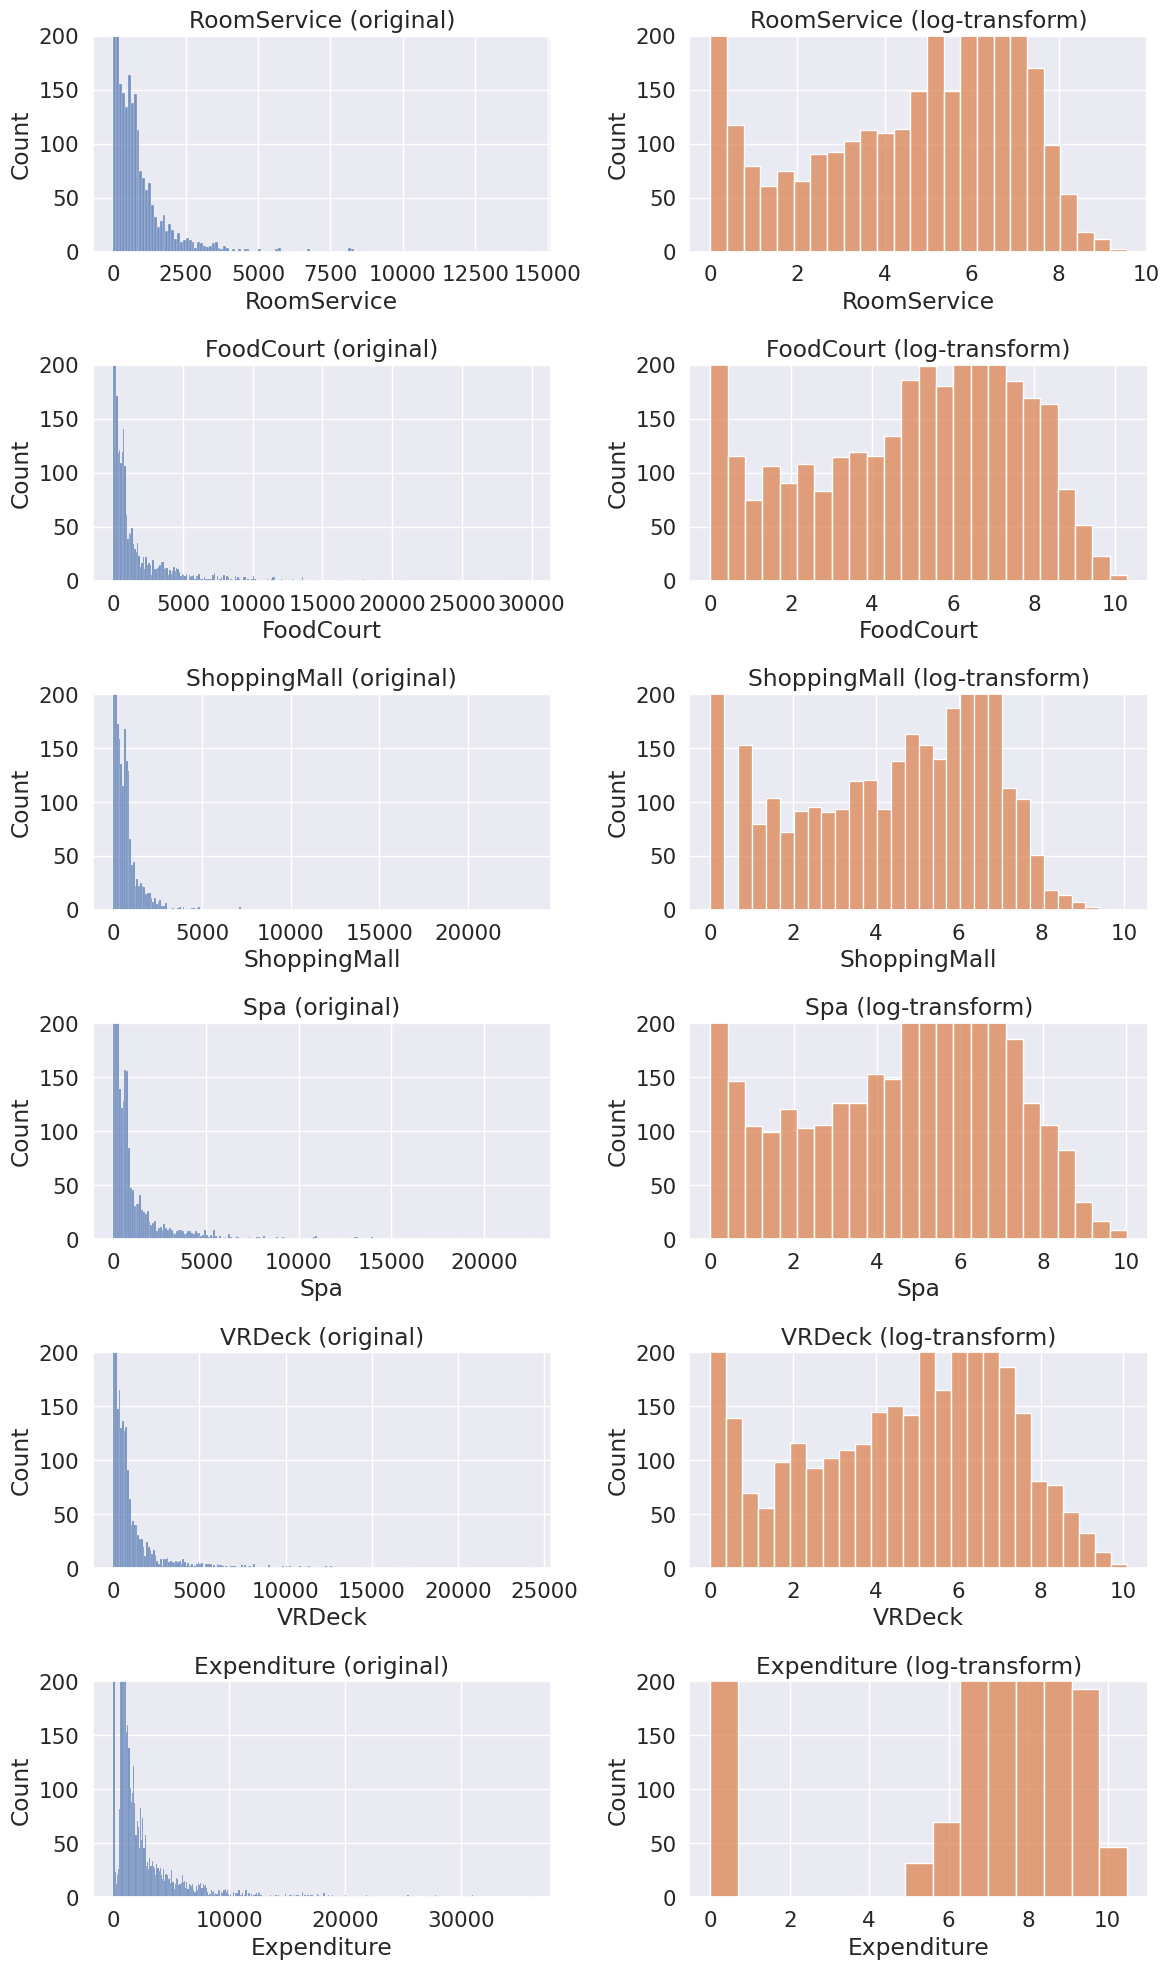

In [127]:
# Plot log transform results
fig=plt.figure(figsize=(12,20))
for i, col in enumerate(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']):
    plt.subplot(6,2,2*i+1)
    sns.histplot(X[col], binwidth=100)
    plt.ylim([0,200])
    plt.title(f'{col} (original)')
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+X[col]), color='C1')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transform)')
    
fig.tight_layout()
plt.show()

可以看到经过对数变换之后分布明显变得比之前更加均匀

In [128]:
X[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']].describe()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Expenditure
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,222.890988,453.064974,171.699093,308.298237,301.479387,1457.432679
std,660.344845,1596.102874,597.803908,1125.533086,1134.171927,2812.033598
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,724.000000
75%,59.000000,86.000000,31.000000,73.000000,54.000000,1448.000000
max,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000


In [129]:
X[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']].head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Expenditure
0,0.0,0.0,0.0,0.0,0.0,0.0
1,109.0,9.0,25.0,549.0,44.0,736.0
2,43.0,3576.0,0.0,6715.0,49.0,10383.0
3,0.0,1283.0,371.0,3329.0,193.0,5176.0
4,303.0,70.0,151.0,565.0,2.0,1091.0


In [130]:
# 对于上面提到的几列应用对数变换
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']:
    X[col]=np.log(1+X[col])
    X_test[col]=np.log(1+X_test[col])

In [131]:
X[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']].describe()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Expenditure
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,1.800191,1.971307,1.658925,1.908129,1.820032,4.279629
std,2.740629,2.950822,2.589337,2.790247,2.766080,3.694250
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,6.586172
75%,4.094345,4.465908,3.465736,4.304065,4.007333,7.278629
max,9.569971,10.302733,10.064458,10.017218,10.091377,10.490941


In [132]:
# 对数变换之后再来看一眼相关性关系
fig = px.imshow(X.corr() ,text_auto=True, aspect="auto" , color_continuous_scale = "viridis")
fig.show()

**对于数据进行编码和进行合理的放缩处理**

为了方便对于不同的列采用不同的操作，我们将使用列转换器对于不同列的数据进行不同的操作

In [133]:
# Print old shape
print('Training set shape old:', X.shape)

# Indentify numerical and categorical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Scale numerical data to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

# Apply preprocessing
X = ct.fit_transform(X)
X_test = ct.transform(X_test)

# Print new shape
print('Training set shape new:', X.shape)

Training set shape old: (8693, 23)
Training set shape new: (8693, 36)


In [134]:
X

array([[ 0.71211024, -0.65689087, -0.66809196, ...,  1.        ,
         0.        ,  0.        ],
       [-0.33064889,  1.05831773,  0.11227278, ...,  0.        ,
         1.        ,  0.        ],
       [ 2.03293847,  0.7239626 ,  2.10494893, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.19161434, -0.65689087, -0.66809196, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.22548931, -0.65689087,  1.68953765, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.05969662,  1.11075641,  2.19668962, ...,  0.        ,
         1.        ,  0.        ]])

In [135]:
print(X_test)

[[-0.12209706 -0.65689087 -0.66809196 ...  0.          1.
   0.        ]
 [-0.67823526 -0.65689087  0.11227278 ...  0.          1.
   0.        ]
 [ 0.15597204 -0.65689087 -0.66809196 ...  0.          1.
   0.        ]
 ...
 [ 0.29500659 -0.65689087 -0.66809196 ...  1.          0.
   0.        ]
 [ 0.36452386 -0.65689087  2.00723    ...  1.          0.
   0.        ]
 [ 0.99017934 -0.65689087 -0.66809196 ...  0.          1.
   0.        ]]


**主成分分析**

In [136]:
pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y, size=0.1*np.ones(len(X)), opacity = 1,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width=800, height=500
)
print("success")
fig.show()
print("success")

success


success


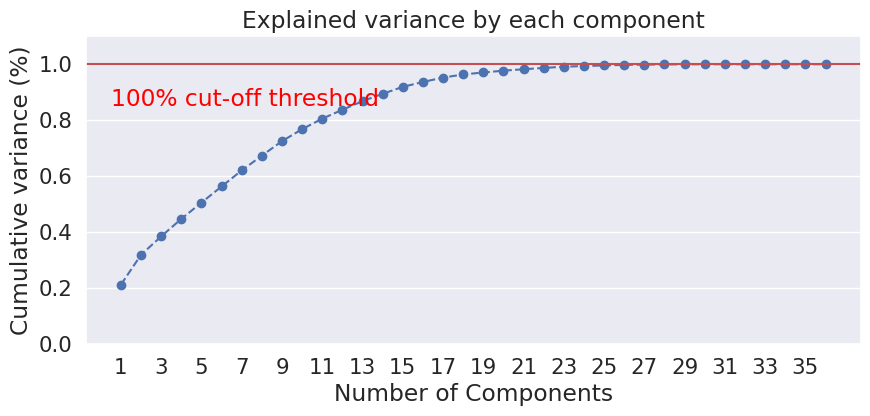

In [137]:
# Explained variance (how important each additional principal component is)
pca = PCA().fit(X)
fig, ax = plt.subplots(figsize=(10,4))
xi = np.arange(1, 1+X.shape[1], step=1)
yi = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

# Aesthetics
plt.ylim(0.0,1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+X.shape[1], step=2))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance by each component')
plt.axhline(y=1, color='r', linestyle='-')
plt.text(0.5, 0.85, '100% cut-off threshold', color = 'red')
ax.grid(axis='x')

**创建一个验证集**

我们将使用验证集来确实使用什么样的模型

In [138]:
# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

## 模型建立

In [139]:
from IPython.display import clear_output
!pip3 install -U lazypredict
!pip3 install -U pandas #Upgrading pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 57.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.1.2 requires pandas!=1.4.0,<1.6,>1.1, but you have pandas 2.0.1 which is incompatible.
woodwork 0.23.0 requires pandas<2.0.0,>=1.4.3, but you have pandas 2.0.1 which is incompatible.
wfdb 4.1.0 requires pandas<2.0.0,>=1.0.0, but you have pandas 2.0.1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.9.3 which is incompatible.
featuretools 1.25.0 requires pandas<2.0.0,>=1.5.0, but you have pandas 2.0.1 which is incompatible.
beatrix-jupyter

In [140]:
import lazypredict
from lazypredict.Supervised import LazyClassifier
print("success")

success


用一下lazypredict库里面的训练模型把所有又可能能用得上的模型全部试一遍

In [141]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     predictions=False,
                     random_state=12,
                     classifiers='all')

models, predictions = clf.fit(X_train, X_valid, y_train, y_valid)

100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


展示一下所有训练模型的训练结果

In [142]:
models[:29]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.79,0.79,0.79,0.79,0.96
XGBClassifier,0.79,0.79,0.79,0.79,2.02
AdaBoostClassifier,0.79,0.79,0.79,0.79,0.57
SVC,0.78,0.78,0.78,0.78,2.31
NuSVC,0.78,0.78,0.78,0.78,2.96
RandomForestClassifier,0.78,0.78,0.78,0.77,1.31
RidgeClassifierCV,0.77,0.77,0.77,0.77,0.24
LinearDiscriminantAnalysis,0.77,0.77,0.77,0.77,0.24
RidgeClassifier,0.77,0.77,0.77,0.77,0.06


对于结果进行可视化

In [143]:
line = px.line(data_frame= models ,y =["Accuracy"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "Accuracy")
line.update_traces(line_color="red")
line.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

In [144]:
line = px.line(data_frame= models ,y =["ROC AUC" , "F1 Score"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "ROC AUC SCORE")
line.update_layout(showlegend = True,
    title = {
        'text': 'ROC AUC and F1 Score vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

In [145]:
line = px.line(data_frame= models ,y =["Time Taken"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "Time(s)")
line.update_traces(line_color="purple")
line.update_layout(showlegend = True,
    title = {
        'text': 'TIME TAKEN vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

从lazypredict的结果看来三种效果最好的模型是LGBM，XGB，AdaBoost三种模型，我们将尝试用三种模型进行投票来决定

In [146]:
#导入voteingClassifier
from sklearn.ensemble import VotingClassifier
#导入AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

# 用LGBM ,XGB ,AdaBoost 进行投票
clf = VotingClassifier(estimators=[('lgbm', LGBMClassifier(random_state=0)),
                                      ('xgb', XGBClassifier(random_state=0)),
                                        ('ada', AdaBoostClassifier(random_state=0))],
                                        voting='soft')

# Fit model
clf.fit(X_train, y_train)

# Predict on test set
preds=clf.predict(X_test)

# 检测模型的准确率
print('Accuracy:',accuracy_score(y_valid, clf.predict(X_valid)))


Accuracy: 0.7952846463484762


之前lazypredict好像没有做catboost，我拿catboost来尝试一下

In [147]:
# 尝试catboost
from catboost import CatBoostClassifier

# Initialize CatBoostClassifier
clf = CatBoostClassifier(random_state=0, verbose=0)

# Fit model
clf.fit(X_train, y_train)

# Predict on test set
preds=clf.predict(X_test)

# 检测模型的准确率
print('Accuracy:',accuracy_score(y_valid, clf.predict(X_valid)))


Accuracy: 0.8021851638872916


In [148]:
# 综合catboost，xgb, lgbm, adaboost四种来尝试一下投票结果怎么样
clf = VotingClassifier(estimators=[('lgbm', LGBMClassifier(random_state=0)),
                                        ('xgb', XGBClassifier(random_state=0)),
                                        ('ada', AdaBoostClassifier(random_state=0)),
                                        ('cat', CatBoostClassifier(random_state=0, verbose=0))],
                                        voting='soft')

# Fit model
clf.fit(X_train, y_train)

# Predict on test set
preds=clf.predict(X_test)

# 检测模型的准确率
print('Accuracy:',accuracy_score(y_valid, clf.predict(X_valid)))

Accuracy: 0.7987349051178838


之前都是软投票我改成硬投票来试一下看看结果怎么样

In [149]:
# 综合catboost，xgb, lgbm, adaboost四种来尝试一下投票结果怎么样
clf = VotingClassifier(estimators=[('lgbm', LGBMClassifier(random_state=0)),
                                        ('xgb', XGBClassifier(random_state=0)),
                                        ('ada', AdaBoostClassifier(random_state=0)),
                                        ('cat', CatBoostClassifier(random_state=0, verbose=0))],
                                        voting='hard')

# Fit model
clf.fit(X_train, y_train)

# Predict on test set
preds=clf.predict(X_test)

# 检测模型的准确率
print('Accuracy:',accuracy_score(y_valid, clf.predict(X_valid)))

Accuracy: 0.7998849913743531


略有改善

在来试一下改变不同投票器的权重，先做第一次尝试，把之前参与投票的模型的单个的正确率作为投票的权重来看看效果

In [150]:
# 综合catboost，xgb, lgbm, adaboost四种来尝试一下投票结果怎么样
clf = VotingClassifier(estimators=[('lgbm', LGBMClassifier(random_state=0)),
                                        ('xgb', XGBClassifier(random_state=0)),
                                        ('ada', AdaBoostClassifier(random_state=0)),
                                        ('cat', CatBoostClassifier(random_state=0, verbose=0))],
                                        voting='hard',
                                        weights=[0.8, 0.79, 0.79, 0.79]
                      )

# Fit model
clf.fit(X_train, y_train)

# Predict on test set
preds=clf.predict(X_test)

# 检测模型的准确率
print('Accuracy:',accuracy_score(y_valid, clf.predict(X_valid)))

Accuracy: 0.8004600345025877


In [151]:
# 综合catboost，xgb, lgbm, adaboost四种来尝试一下投票结果怎么样
clf = VotingClassifier(estimators=[('lgbm', LGBMClassifier(random_state=0)),
                                        ('xgb', XGBClassifier(random_state=0)),
                                        ('ada', AdaBoostClassifier(random_state=0)),
                                        ('cat', CatBoostClassifier(random_state=0, verbose=0))],
                                        voting='hard',
                                        weights=[2, 1, 1, 1]
                      )

# Fit model
clf.fit(X_train, y_train)

# Predict on test set
preds=clf.predict(X_test)

# 检测模型的准确率
print('Accuracy:',accuracy_score(y_valid, clf.predict(X_valid)))

Accuracy: 0.8004600345025877


In [152]:
# 再朴素的看看catboost的表现吧
# 尝试catboost
from catboost import CatBoostClassifier

# Initialize CatBoostClassifier
clf = CatBoostClassifier(random_state=0, verbose=0)

# Fit model
clf.fit(X_train, y_train)

# Predict on test set
preds=clf.predict(X_test)

# 检测模型的准确率
print('Accuracy:',accuracy_score(y_valid, clf.predict(X_valid)))


Accuracy: 0.8021851638872916


试验了半天其实就catboost单独的表现似乎最好

对于catboost搞一波调参看看有没有改进

In [153]:
# 对于catboost进行调参
from sklearn.model_selection import GridSearchCV

# Initialize CatBoostClassifier
clf = CatBoostClassifier(random_state=0, verbose=0)

# Create the parameter grid
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.1, 0.15],
    'l2_leaf_reg': [1,4,9],
    'iterations': [300]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit model
grid_search.fit(X_train, y_train)

# Predict on test set
preds=grid_search.predict(X_test)

# 检测模型的准确率
print('Accuracy:',accuracy_score(y_valid, grid_search.predict(X_valid)))


Accuracy: 0.80448533640023


交叉验证

In [154]:
#交叉验证
from sklearn.model_selection import cross_val_score

# Initialize CatBoostClassifier

clf = CatBoostClassifier(random_state=0, verbose=0)

# Perform 5-fold cross validation
scores = cross_val_score(clf, X, y, cv=5)

# Print average
print('Average accuracy:',np.round(scores.mean(),3))

Average accuracy: 0.799
